In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

%matplotlib inline
%config InlineBackend.figure_formats = {'png','retina'}

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

pd.set_option('display.max_rows', 30000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import pandas_profiling as pdp

C:\Users\creal\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


---

# Shelter Animal Outcomes
- 유기 동물 보호소에서 동물들이 어떤 결과를 가져올 것인가를 예측
- 데이터 크기는 작지만 주제가 흥미롭고, 외부 데이터를 사용해보거나, breed, color의 텍스트 데이터를 어떻게 처리할 것인가에 대한 고민이 주요포인트
- https://www.kaggle.com/c/shelter-animal-outcomes

In [2]:
df_train_animal = pd.read_csv("train.csv")
print(df_train_animal.shape)
df_train_animal.tail(3)

(26729, 10)


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
26726,A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,NaN,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black
26728,A706629,NaN,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White


# 1. 기본정보 파악 및 사전작업

In [3]:
# 1-1. 대부분이 카테고리형 데이터
print('◆데이터 간략 정보')
df_train_animal.info()

◆데이터 간략 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


In [4]:
print("◆컬럼별 null의 갯수")
pd.DataFrame(df_train_animal.isnull().sum())

◆컬럼별 null의 갯수


,0
AnimalID,0
Name,7691
DateTime,0
OutcomeType,0
OutcomeSubtype,13612
AnimalType,0
SexuponOutcome,1
AgeuponOutcome,18
Breed,0
Color,0


In [85]:
print('◆중복자료 및 unique')
df_train_animal.describe().T

◆중복자료 및 unique


,count,unique,top,freq
AnimalID,26729,26729,A711169,1
Name,19038,6374,Max,136
DateTime,26729,22918,2015-08-11 00:00:00,19
OutcomeType,26729,5,Adoption,10769
OutcomeSubtype,13117,16,Partner,7816
AnimalType,26729,2,Dog,15595
SexuponOutcome,26728,5,Neutered Male,9779
AgeuponOutcome,26711,44,1 year,3969
Breed,26729,1380,Domestic Shorthair Mix,8810
Color,26729,366,Black/White,2824


> ### 정형화 방법
1. 모든 데이터 라벨링
2. Name --> 이름 유무여부를 알 수 있는 column 추출
3. DateTime --> Day of Week, year, month, day, 추출
4. OutcomeType --> live, dead로 성격 구분하는 column 추출
5. OutcomeSubType -->
6. AnimalType --> Cat, Dog를 OHE화(필요할때 해도 될드ㅅ)


In [6]:
print("◆OutcomeType의 내용")
df_train_animal["OutcomeType"].value_counts()#.groupby("OutcomeType").size().reset_index(name='count').sort_values('count',ascending=False)

◆OutcomeType의 내용


Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [7]:
print("◆OutcomeSubtype의 내용")
df_train_animal.groupby("OutcomeSubtype").size().reset_index(name='count').sort_values('count',ascending=False)

◆OutcomeSubtype의 내용


,OutcomeSubtype,count
12,Partner,7816
6,Foster,1800
14,SCRP,1599
15,Suffering,1002
0,Aggressive,320
11,Offsite,165
8,In Kennel,114
3,Behavior,86
13,Rabies Risk,74
10,Medical,66


In [8]:
print("◆AnimalType의 내용")
df_train_animal.groupby("AnimalType").size().reset_index(name='count').sort_values('count',ascending=False)

◆AnimalType의 내용


,AnimalType,count
1,Dog,15595
0,Cat,11134


In [9]:
print("◆SexuponOutcome의 내용")
df_train_animal.groupby("SexuponOutcome").size().reset_index(name='count').sort_values('count', ascending=False)

◆SexuponOutcome의 내용


,SexuponOutcome,count
2,Neutered Male,9779
3,Spayed Female,8820
1,Intact Male,3525
0,Intact Female,3511
4,Unknown,1093


In [10]:
print("◆AgeuponOutcome의 내용")
print("   ※10개만 표시되고 중략됨")
df_train_animal.groupby("AgeuponOutcome").size().reset_index(name='count').sort_values('count', ascending=False).head(10)

◆AgeuponOutcome의 내용
   ※10개만 표시되고 중략됨


,AgeuponOutcome,count
5,1 year,3969
21,2 years,3742
19,2 months,3397
26,3 years,1823
2,1 month,1281
24,3 months,1277
30,4 years,1071
34,5 years,992
28,4 months,888
37,6 years,670


In [11]:
print("◆Breed의 내용")
print("   15개 항목만 표시되고 중략됨")
df_train_animal.groupby("Breed").size().reset_index(name='count').sort_values('count', ascending=False).head(50)

◆Breed의 내용
   15개 항목만 표시되고 중략됨


,Breed,count
640,Domestic Shorthair Mix,8810
1066,Pit Bull Mix,1906
450,Chihuahua Shorthair Mix,1766
847,Labrador Retriever Mix,1363
637,Domestic Medium Hair Mix,839
696,German Shepherd Mix,575
632,Domestic Longhair Mix,520
1251,Siamese Mix,389
74,Australian Cattle Dog Mix,367
559,Dachshund Mix,318


In [12]:
print("◆Color의 내용")
print("   15개 항목만 표시되고 중략됨")
df_train_animal.groupby("Color").size().reset_index(name='count').sort_values('count', ascending=False).head(15)

◆Color의 내용
   15개 항목만 표시되고 중략됨


,Color,count
38,Black/White,2824
5,Black,2292
104,Brown Tabby,1635
111,Brown Tabby/White,940
318,White,931
130,Brown/White,884
216,Orange Tabby,841
289,Tan/White,773
307,Tricolor,752
86,Blue/White,702


### 1-1) 비정형데이터 --> 정형화

In [13]:
# 분석 베이스로 사용되는 데이터프레임 명칭지정 ==> df_shelter
df_shelter = df_train_animal.copy()

# Name column --> 이름이 존재하는 동물과 그렇지 않은 동물을 구분하는 컬럼 생성
df_shelter["Name_exsist"] = df_shelter["Name"].isnull().astype(int)

In [14]:
# NaN값 처리
df_shelter["OutcomeSubtype"] = df_shelter["OutcomeSubtype"].fillna("NoStatus")
df_shelter["SexuponOutcome"] = df_shelter["SexuponOutcome"].fillna("Unknown")
df_shelter["AgeuponOutcome"] = df_shelter["AgeuponOutcome"].fillna("-1 nodata")

# (연령을 알 수 없는 경우 -1로 표기)

# 동물의 연령column 세부구분필요
df_shelter["AgeuponOutcome"].unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years',
       '-1 nodata', '17 years', '18 years', '19 years', '20 years'], dtype=object)

In [15]:
# 나이데이터 정제

df_shelter["Age_nbr"] = df_shelter["AgeuponOutcome"].str.slice(0,2).astype(int) # 0인값의경우 해당 동물의 나이정보가 없는것으로 추정한다
df_shelter["Age_tscale"] = df_shelter["AgeuponOutcome"].str.split(" ", n=2, expand=True)[1] # 띄어쓰기 된 뒷문장 가져오기
df_shelter["Age_tscale"] = df_shelter["Age_tscale"].replace("s","",regex=True) # 문자 s를 삭제
df_shelter["Age_yscale"] = df_shelter["Age_tscale"].replace(["day","week","month"],"under_year")
df_shelter["Age_ynbr"] = df_shelter["Age_nbr"].copy()
df_shelter.Age_ynbr[df_shelter["Age_yscale"]=="under_year"] = 0

df_shelter["Age_code"] = 'Y'

ls = []
for data in df_shelter.iloc[:,:].values:
    if data[-4] == "day":
        ls.append("D_"+str(data[-5]))
    elif data[-4] == "week":
        ls.append("K_"+str(data[-5]))
    elif data[-4] == "month":
        if (data[-5]>=10):
            ls.append("M_"+str(data[-5]))
        else : 
            ls.append("M_0"+str(data[-5]))
    elif data[-4] == "nodata":
        ls.append("A_nodata")
    elif data[-4] == "year":
        ls.append("Y_"+str(data[-5]))
df_shelter["Age_code"] = ls    

# df_shelter.tail(5)

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
# 성별구분
df_shelter["intact_b"] = (df_shelter["SexuponOutcome"].str.slice(0,6) == "Intact").astype(int)
df_shelter["sex_unknown"] = (df_shelter["SexuponOutcome"] == "Unknown").astype(int)
df_shelter["Male_b"] = (df_shelter["SexuponOutcome"].str.split(' ', n=2, expand=True)[1] == "Male").astype(int)

In [17]:
# 처분결과 생존여부 및 기타(개벼ㄹ 결과물 얻기위해 만들어봄)
df_shelter["Survived"] = 0
df_shelter.Survived[(df_shelter["OutcomeType"]=="Transfer")|(df_shelter["OutcomeType"]=="Adoption")|(df_shelter["OutcomeType"]=="Return_to_owner")] = 1
df_shelter["Euthanasia_b"] = (df_shelter["OutcomeType"]=="Euthanasia").astype(int)
df_shelter["Transfer_b"] = (df_shelter["OutcomeType"]=="Transfer").astype(int)
df_shelter["Adoption_b"] = (df_shelter["OutcomeType"]=="Adoption").astype(int)
df_shelter["Died_b"] = (df_shelter["OutcomeType"]=="Died").astype(int)
df_shelter["Return_b"] = (df_shelter["OutcomeType"]=="Return_to_owner").astype(int)
# df_shelter["OutcomeType_c"]
# df_shelter.tail()

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
#라벨인코딩 ()

from sklearn.preprocessing import LabelEncoder

OT = LabelEncoder()
y_outc = df_shelter["OutcomeType"]
OT.fit(y_outc)
df_shelter["OutcomeType_c"] = OT.transform(y_outc)
animal = LabelEncoder()

OS = LabelEncoder()
y = df_shelter["OutcomeSubtype"]
OS.fit(y)
df_shelter["OutcomeSubtype_c"] = OS.transform(y)

AT = LabelEncoder()
y = df_shelter["AnimalType"]
AT.fit(y)
df_shelter["AnimalType_c"] = AT.transform(y)

SO = LabelEncoder()
y = df_shelter["SexuponOutcome"]
SO.fit(y)
df_shelter["SexuponOutcome_c"] = SO.transform(y)

Br = LabelEncoder()
y = df_shelter["Breed"]
Br.fit(y)
df_shelter["Breed_c"] = Br.transform(y)

Col = LabelEncoder()
y = df_shelter["Color"]
Col.fit(y)
df_shelter["Color_c"] = Col.transform(y)


# y2.tail()

In [19]:
# Breed 종류별 정제
# df_shelter = df_shelter.drop("Breed_domestic", axis=1)
df_shelter["Breed_normal"] = df_shelter["Breed"].replace(["Domestic","Mix"," ","Shorthair","Longhair",""],"",regex=True) # 문자 s를 삭제
df_shelter["Breed_Domestic"] = (df_shelter["Breed"].str.contains("Domestic", regex=True)).astype(int)
df_shelter["Breed_Mix"] = (df_shelter["Breed"].str.contains("Mix", regex=True)).astype(int)
df_shelter["Breed_Lhair"] = (df_shelter["Breed"].str.contains("Longhair", regex=True)).astype(int)
df_shelter["Breed_Shair"] = (df_shelter["Breed"].str.contains("Shorthair", regex=True)).astype(int)
df_shelter.tail(10)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Name_exsist,Age_nbr,Age_tscale,Age_yscale,Age_ynbr,Age_code,intact_b,sex_unknown,Male_b,Survived,Euthanasia_b,Transfer_b,Adoption_b,Died_b,Return_b,OutcomeType_c,OutcomeSubtype_c,AnimalType_c,SexuponOutcome_c,Breed_c,Color_c,Breed_normal,Breed_Domestic,Breed_Mix,Breed_Lhair,Breed_Shair
26719,A707871,NaN,2015-07-20 09:00:00,Transfer,SCRP,Cat,Unknown,2 years,Domestic Shorthair Mix,Brown Tabby/White,1,2,year,year,2,Y_2,0,1,0,1,0,1,0,0,0,4,15,0,4,640,111,,1,1,0,1
26720,A704405,Brownie,2015-07-18 14:08:00,Adoption,NoStatus,Cat,Spayed Female,2 months,Domestic Shorthair Mix,Brown Tabby,0,2,month,under_year,0,M_02,0,0,0,1,0,0,1,0,0,0,11,0,3,640,104,,1,1,0,1
26721,A662019,Green Bean,2014-07-17 09:43:00,Adoption,Foster,Cat,Spayed Female,5 years,Domestic Shorthair Mix,Black,0,5,year,year,5,Y_5,0,0,0,1,0,0,1,0,0,0,6,0,3,640,5,,1,1,0,1
26722,A687056,NaN,2014-08-31 09:00:00,Transfer,SCRP,Cat,Intact Male,5 months,Domestic Shorthair Mix,Orange Tabby,1,5,month,under_year,0,M_05,1,0,1,1,0,1,0,0,0,4,15,0,1,640,216,,1,1,0,1
26723,A716997,Zeus,2016-01-29 18:52:00,Adoption,NoStatus,Dog,Neutered Male,6 years,Staffordshire Mix,Blue/White,0,6,year,year,6,Y_6,0,0,1,1,0,0,1,0,0,0,11,1,2,1291,86,Staffordshire,0,1,0,0
26724,A702446,NaN,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White,1,1,month,under_year,0,M_01,1,0,1,1,0,1,0,0,0,4,13,0,1,640,111,,1,1,0,1
26725,A718934,NaN,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby,1,3,month,under_year,0,M_03,0,0,0,1,0,1,0,0,0,4,15,0,3,640,104,,1,1,0,1
26726,A698128,Zeus,2015-03-09 13:33:00,Adoption,NoStatus,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,0,4,year,year,4,Y_4,0,0,1,1,0,0,1,0,0,0,11,1,2,1022,353,OldEnglishBulldog,0,1,0,0
26727,A677478,NaN,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black,1,4,week,under_year,0,K_4,1,0,1,1,0,1,0,0,0,4,13,0,1,640,5,,1,1,0,1
26728,A706629,NaN,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White,1,1,year,year,1,Y_1,1,0,1,1,0,1,0,0,0,4,15,0,1,640,111,,1,1,0,1


# 2. 변수 종합 분석

In [20]:
df_shelter[(df_shelter["OutcomeSubtype"]!="Suffering")&(df_shelter["OutcomeType"]=="Euthanasia")].reset_index(drop=True)
# 1. 고통을 겪는 동물 = 모두 안락사되었다(예외가 없다니...)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Name_exsist,Age_nbr,Age_tscale,Age_yscale,Age_ynbr,Age_code,intact_b,sex_unknown,Male_b,Survived,Euthanasia_b,Transfer_b,Adoption_b,Died_b,Return_b,OutcomeType_c,OutcomeSubtype_c,AnimalType_c,SexuponOutcome_c,Breed_c,Color_c,Breed_normal,Breed_Domestic,Breed_Mix,Breed_Lhair,Breed_Shair
0,A666092,NaN,2013-10-30 15:37:00,Euthanasia,Aggressive,Dog,Intact Male,6 years,Pit Bull/Labrador Retriever,Chocolate/White,1,6,year,year,6,Y_6,1,0,1,0,1,0,0,0,0,2,0,1,1,1091,165,PitBull/LabradorRetriever,0,0,0,0
1,A676680,Hero,2015-02-06 18:56:00,Euthanasia,Aggressive,Dog,Spayed Female,2 years,German Shepherd Mix,Black/Tan,0,2,year,year,2,Y_2,0,0,0,0,1,0,0,0,0,2,0,1,3,696,36,GermanShepherd,0,1,0,0
2,A657753,Wiz,2013-12-06 16:53:00,Euthanasia,Aggressive,Dog,Neutered Male,1 year,Chihuahua Shorthair/Dachshund,Yellow Brindle/White,0,1,year,year,1,Y_1,0,0,1,0,1,0,0,0,0,2,0,1,2,463,362,Chihuahua/Dachshund,0,0,0,1
3,A487470,Midnight,2014-01-20 18:40:00,Euthanasia,Aggressive,Dog,Neutered Male,9 years,Labrador Retriever/Pit Bull,Black,0,9,year,year,9,Y_9,0,0,1,0,1,0,0,0,0,2,0,1,2,890,5,LabradorRetriever/PitBull,0,0,0,0
4,A683309,NaN,2014-07-17 18:06:00,Euthanasia,Behavior,Dog,Spayed Female,7 years,Pit Bull Mix,Tan/White,1,7,year,year,7,Y_7,0,0,0,0,1,0,0,0,0,2,3,1,3,1066,289,PitBull,0,1,0,0
5,A674659,NaN,2014-03-21 17:10:00,Euthanasia,Aggressive,Dog,Intact Male,2 years,Labrador Retriever/Great Dane,Tan/Black,1,2,year,year,2,Y_2,1,0,1,0,1,0,0,0,0,2,0,1,1,880,276,LabradorRetriever/GreatDane,0,0,0,0
6,A678099,Spartacus,2015-06-10 17:23:00,Euthanasia,Aggressive,Dog,Neutered Male,2 years,Akita/Pit Bull,Tan/White,0,2,year,year,2,Y_2,0,0,1,0,1,0,0,0,0,2,0,1,2,13,289,Akita/PitBull,0,0,0,0
7,A672744,Oso,2014-04-17 17:09:00,Euthanasia,Aggressive,Dog,Intact Male,3 years,Rottweiler Mix,Black/Tan,0,3,year,year,3,Y_3,1,0,1,0,1,0,0,0,0,2,0,1,1,1197,36,Rottweiler,0,1,0,0
8,A663346,July,2013-11-10 18:25:00,Euthanasia,Aggressive,Dog,Spayed Female,1 year,Pit Bull Mix,Black/White,0,1,year,year,1,Y_1,0,0,0,0,1,0,0,0,0,2,0,1,3,1066,38,PitBull,0,1,0,0
9,A700335,Dorchester,2015-07-04 08:56:00,Euthanasia,Rabies Risk,Dog,Neutered Male,2 years,Pit Bull Mix,White/Brown,0,2,year,year,2,Y_2,0,0,1,0,1,0,0,0,0,2,14,1,2,1066,329,PitBull,0,1,0,0


In [21]:
df_shelter[df_shelter["Breed_normal"]!=""].tail(40)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Name_exsist,Age_nbr,Age_tscale,Age_yscale,Age_ynbr,Age_code,intact_b,sex_unknown,Male_b,Survived,Euthanasia_b,Transfer_b,Adoption_b,Died_b,Return_b,OutcomeType_c,OutcomeSubtype_c,AnimalType_c,SexuponOutcome_c,Breed_c,Color_c,Breed_normal,Breed_Domestic,Breed_Mix,Breed_Lhair,Breed_Shair
26658,A657681,Blu,2015-10-03 16:27:00,Return_to_owner,NoStatus,Dog,Neutered Male,3 years,Pit Bull Mix,Brown Brindle/White,0,3,year,year,3,Y_3,0,0,1,1,0,0,0,0,1,3,11,1,2,1066,98,PitBull,0,1,0,0
26662,A673187,Leia,2014-02-24 17:49:00,Adoption,NoStatus,Dog,Spayed Female,1 year,Boxer Mix,Brown,0,1,year,year,1,Y_1,0,0,0,1,0,0,1,0,0,0,11,1,3,307,88,Boxer,0,1,0,0
26663,A674506,NaN,2014-03-17 10:36:00,Euthanasia,Suffering,Dog,Intact Male,4 years,Miniature Poodle/Cocker Spaniel,White,1,4,year,year,4,Y_4,1,0,1,0,1,0,0,0,0,2,16,1,1,966,318,MiniaturePoodle/CockerSpaniel,0,0,0,0
26664,A673742,Leah,2014-03-16 17:19:00,Adoption,NoStatus,Dog,Spayed Female,2 years,Carolina Dog Mix,Red,0,2,year,year,2,Y_2,0,0,0,1,0,0,1,0,0,0,11,1,3,401,226,CarolinaDog,0,1,0,0
26665,A720627,Nike,2016-02-14 12:48:00,Return_to_owner,NoStatus,Dog,Neutered Male,1 year,Black Mouth Cur Mix,Tan/White,0,1,year,year,1,Y_1,0,0,1,1,0,0,0,0,1,3,11,1,2,214,289,BlackMouthCur,0,1,0,0
26667,A685875,Bingo,2014-09-30 18:34:00,Adoption,NoStatus,Dog,Neutered Male,1 year,Labrador Retriever Mix,Tan,0,1,year,year,1,Y_1,0,0,1,1,0,0,1,0,0,0,11,1,2,847,274,LabradorRetriever,0,1,0,0
26669,A694580,Rocko,2015-09-19 11:38:00,Return_to_owner,NoStatus,Dog,Neutered Male,1 year,German Shepherd/Labrador Retriever,Tan/Black,0,1,year,year,1,Y_1,0,0,1,1,0,0,0,0,1,3,11,1,2,720,276,GermanShepherd/LabradorRetriever,0,0,0,0
26670,A714656,Patsy,2015-11-15 14:38:00,Transfer,Partner,Dog,Intact Female,1 year,Pit Bull Mix,Blue/White,0,1,year,year,1,Y_1,1,0,0,1,0,1,0,0,0,4,13,1,0,1066,86,PitBull,0,1,0,0
26672,A693469,Lucky,2014-12-08 17:47:00,Return_to_owner,NoStatus,Dog,Neutered Male,1 year,Dachshund Longhair Mix,Black/Tan,0,1,year,year,1,Y_1,0,0,1,1,0,0,0,0,1,3,11,1,2,549,36,Dachshund,0,1,1,0
26674,A653309,Chester,2014-06-10 18:15:00,Return_to_owner,NoStatus,Dog,Neutered Male,2 years,Chihuahua Shorthair,White/Tan,0,2,year,year,2,Y_2,0,0,1,1,0,0,0,0,1,3,11,1,2,449,353,Chihuahua,0,0,0,1


## 2-1) Age-AnimalType

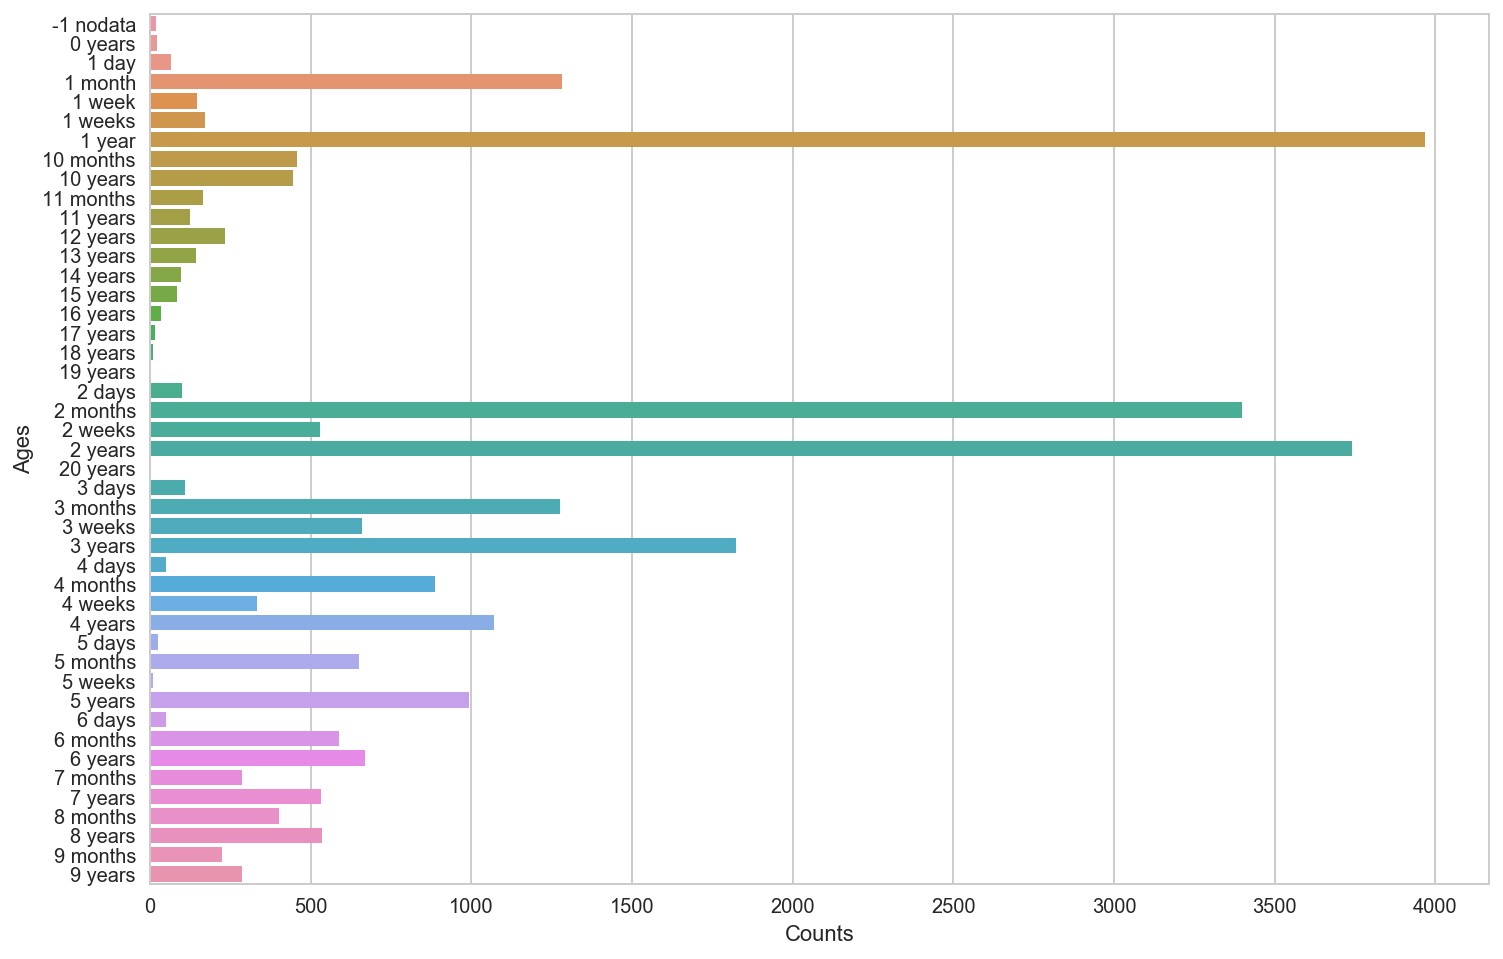

In [22]:
# 일단 기본 나이데이터를  bar로 뿌려봄
sorted_df = df_shelter.groupby("AgeuponOutcome").size().reset_index(name="count")

fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="AgeuponOutcome")

ax.set_ylabel('Ages')
ax.set_xlabel('Counts')

동물의 나이별(년) 개체수 통계


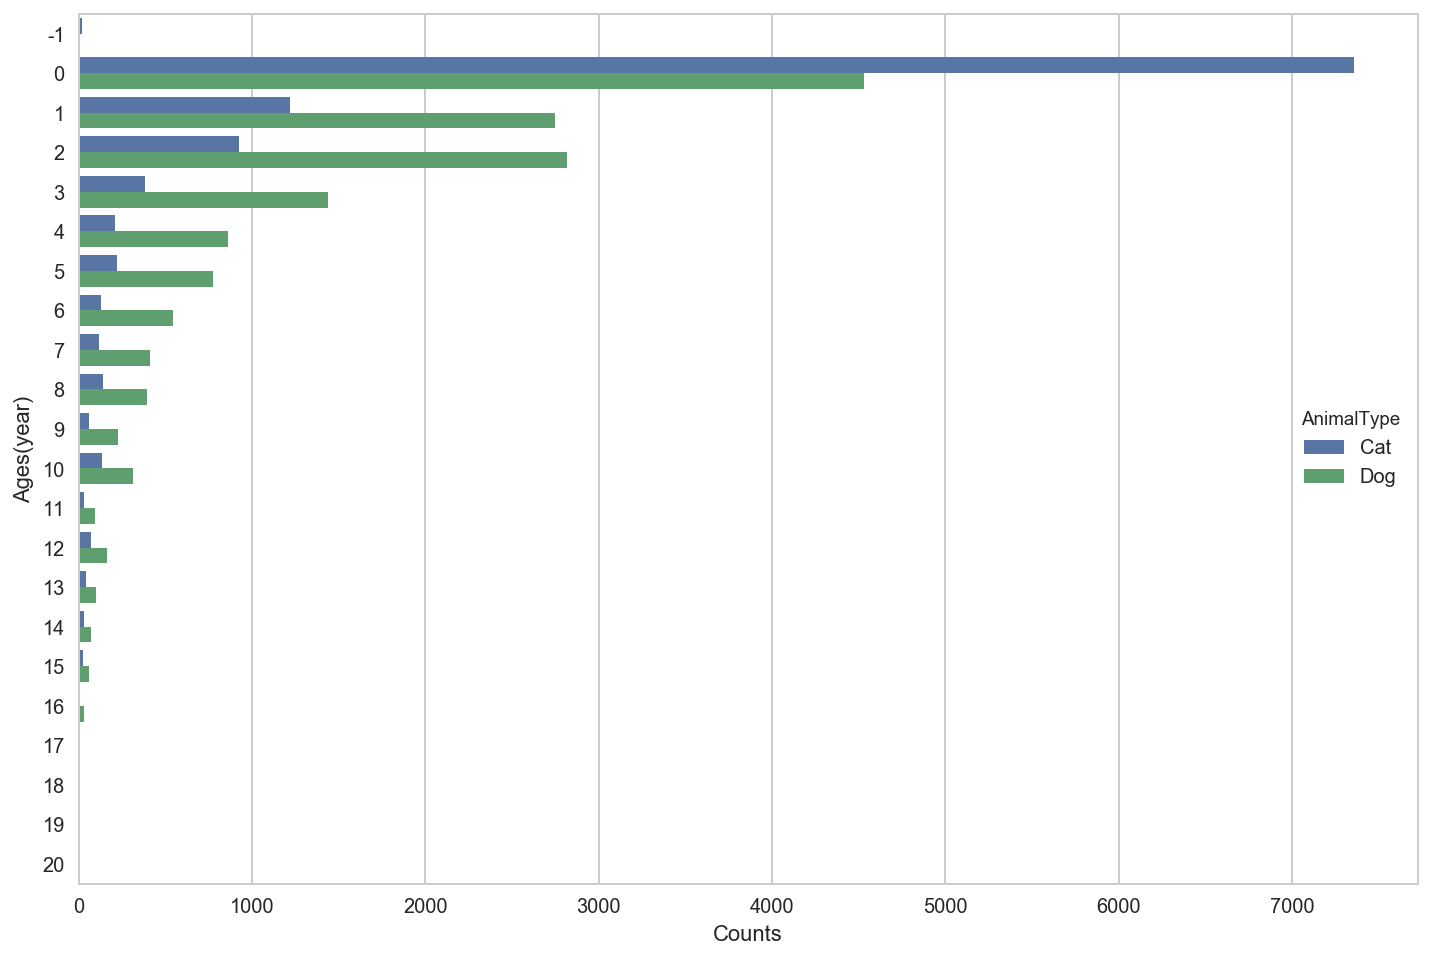

In [23]:
# 위 그래프 정제결과1 : 동

sorted_df = df_shelter.groupby(["Age_ynbr","AnimalType"]).size().reset_index(name="count")
sorted_df['Age_ynbr'] = pd.Categorical(sorted_df['Age_ynbr'])
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="Age_ynbr", hue="AnimalType")
ax.set_xlabel('Counts')
ax.set_ylabel('Ages(year)')
print("동물의 나이별(년) 개체수 통계")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

동물의 나이별(1년미만) 개체수 통계


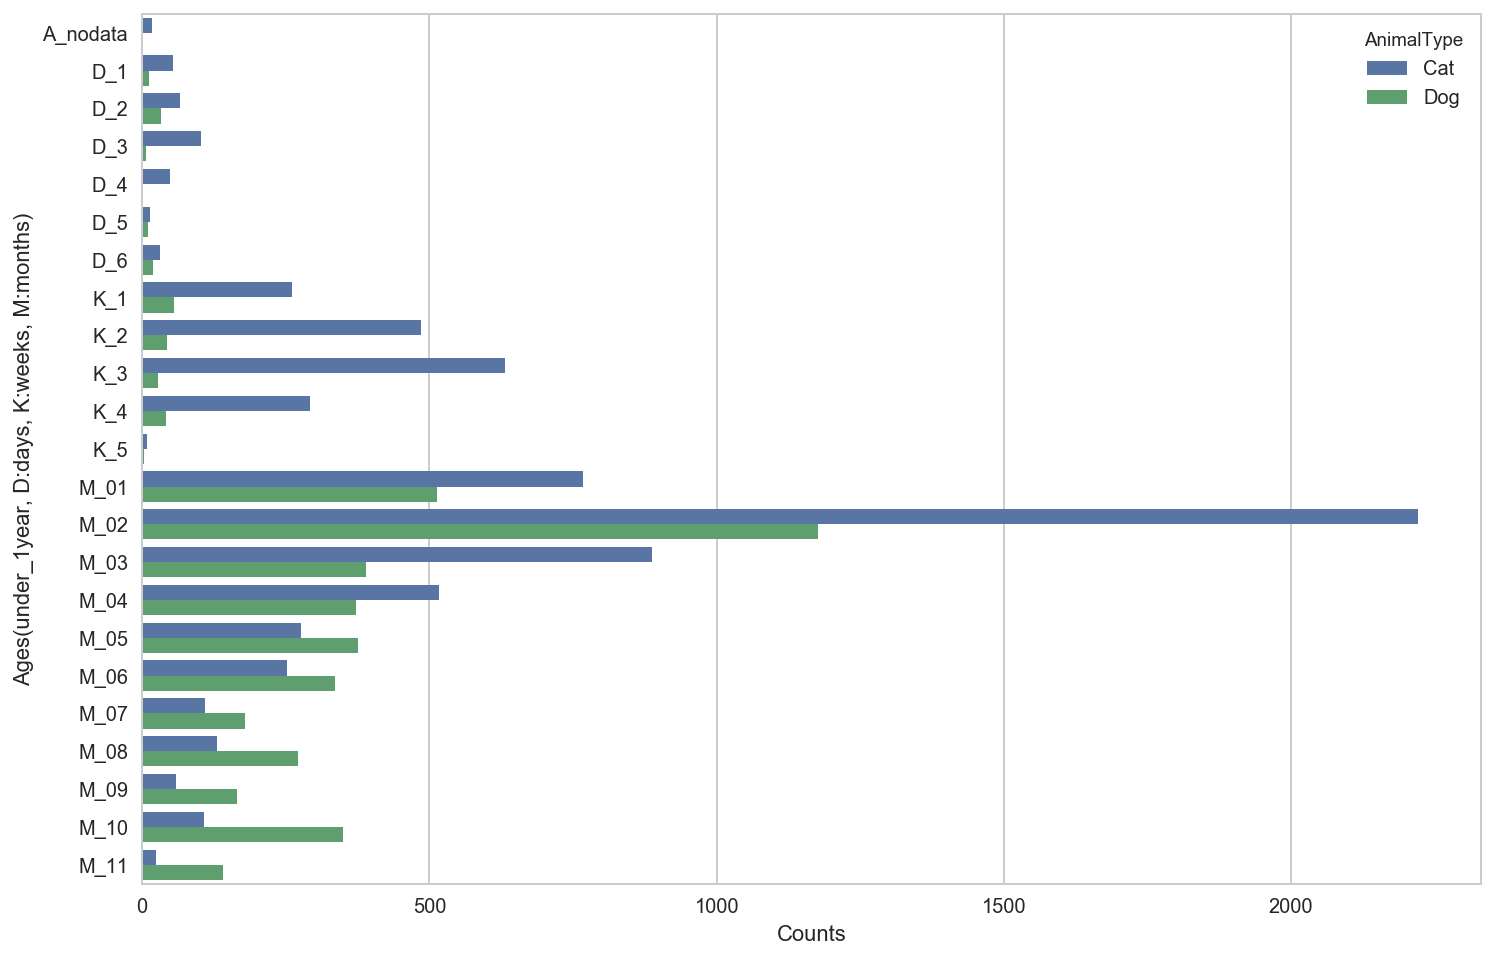

In [24]:
# 위 그래프 정제2 : 1년미만생 통계

sorted_df = df_shelter[df_shelter["Age_yscale"]!="year"].groupby(["Age_code","AnimalType"]).size().reset_index(name="count")
sorted_df['Age_code'] = pd.Categorical(sorted_df['Age_code'])
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="Age_code", hue="AnimalType")
ax.set_xlabel('Counts')
ax.set_ylabel('Ages(under_1year, D:days, K:weeks, M:months)')
print("동물의 나이별(1년미만) 개체수 통계")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

## 2-2) Age-OutcomeType(Y)

고양이의 나이별(년) 개체수 통계 - 처리결과 그래프


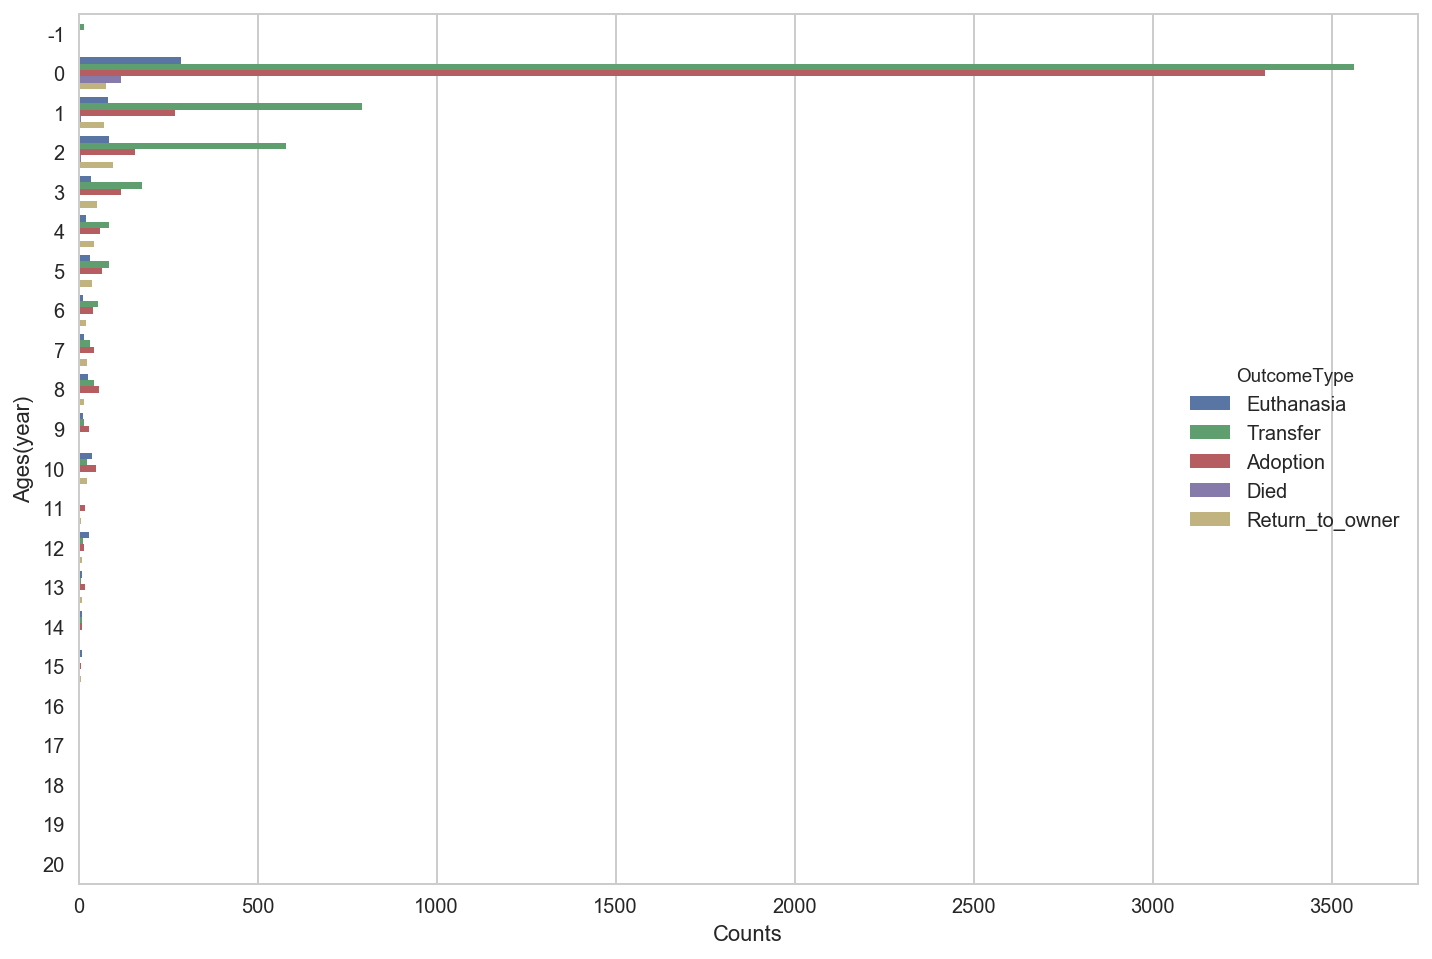

In [25]:
# 처리결과 비교 (정규화는 하지않은상태)

sorted_df = df_shelter.groupby(["Age_ynbr","OutcomeType","AnimalType"]).size().reset_index(name="count")
sorted_df['Age_ynbr'] = pd.Categorical(sorted_df['Age_ynbr'])
fig = plt.figure(figsize=(12,8))

ax = sns.barplot(data = sorted_df[sorted_df["AnimalType"]=="Cat"], x="count", y="Age_ynbr", hue="OutcomeType")
ax.set_xlabel('Counts')
ax.set_ylabel('Ages(year)')
print("고양이의 나이별(년) 개체수 통계 - 처리결과 그래프")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

개의 나이별(년) 개체수 통계 - 처리결과 그래프


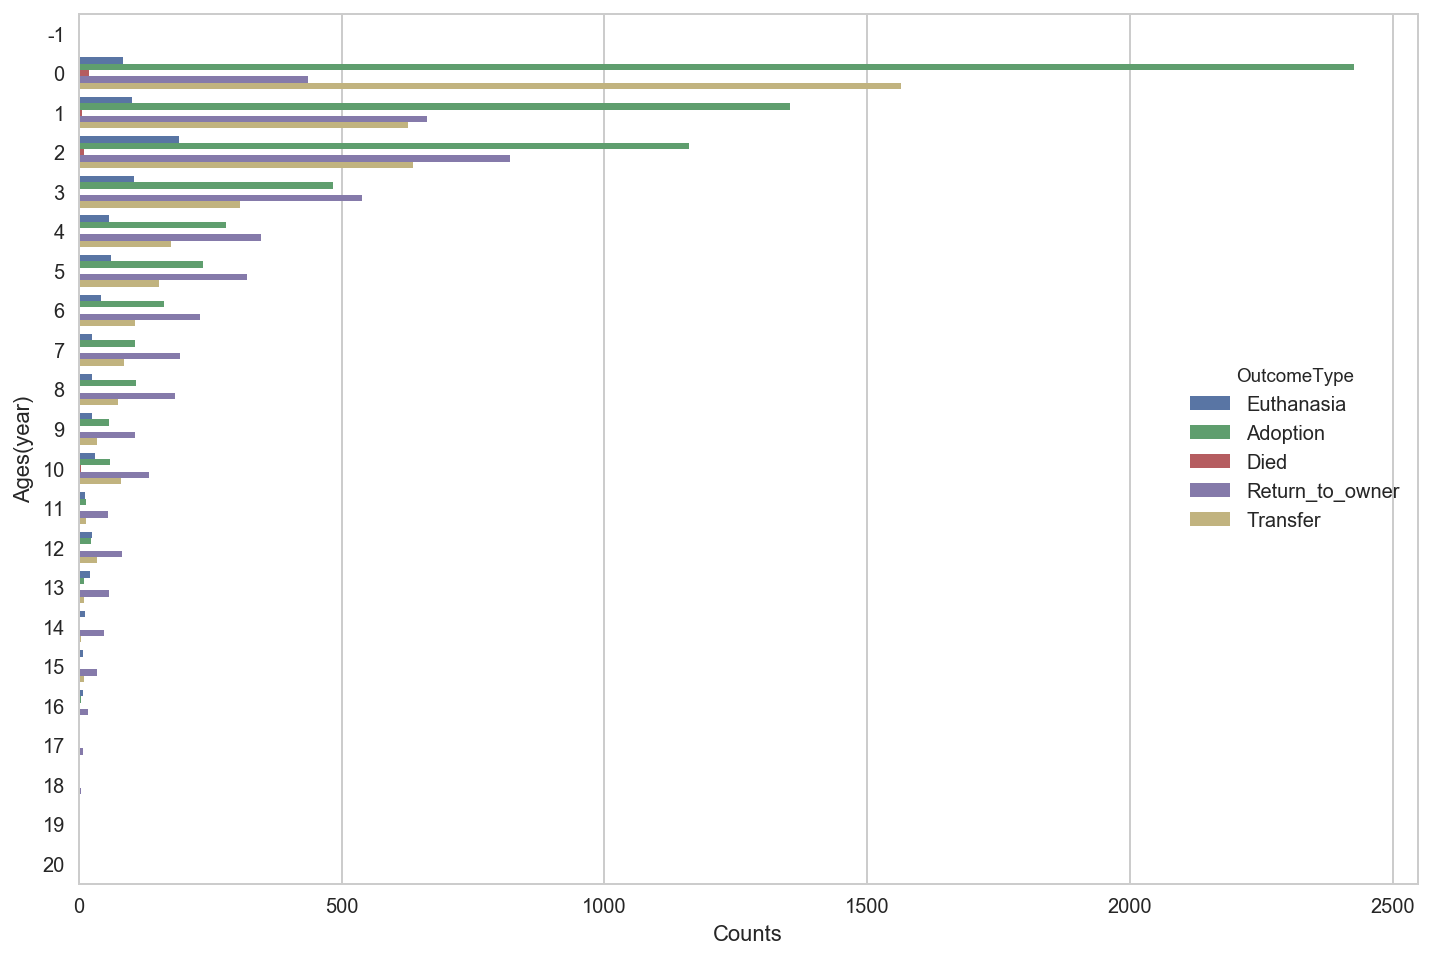

In [26]:
# 처리결과 비교 (정규화는 하지않은상태)

fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df[sorted_df["AnimalType"]=="Dog"], x="count", y="Age_ynbr", hue="OutcomeType")
ax.set_xlabel('Counts')
ax.set_ylabel('Ages(year)')
print("개의 나이별(년) 개체수 통계 - 처리결과 그래프")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

고양이의 나이별(1년미만) - 처리결과 통계


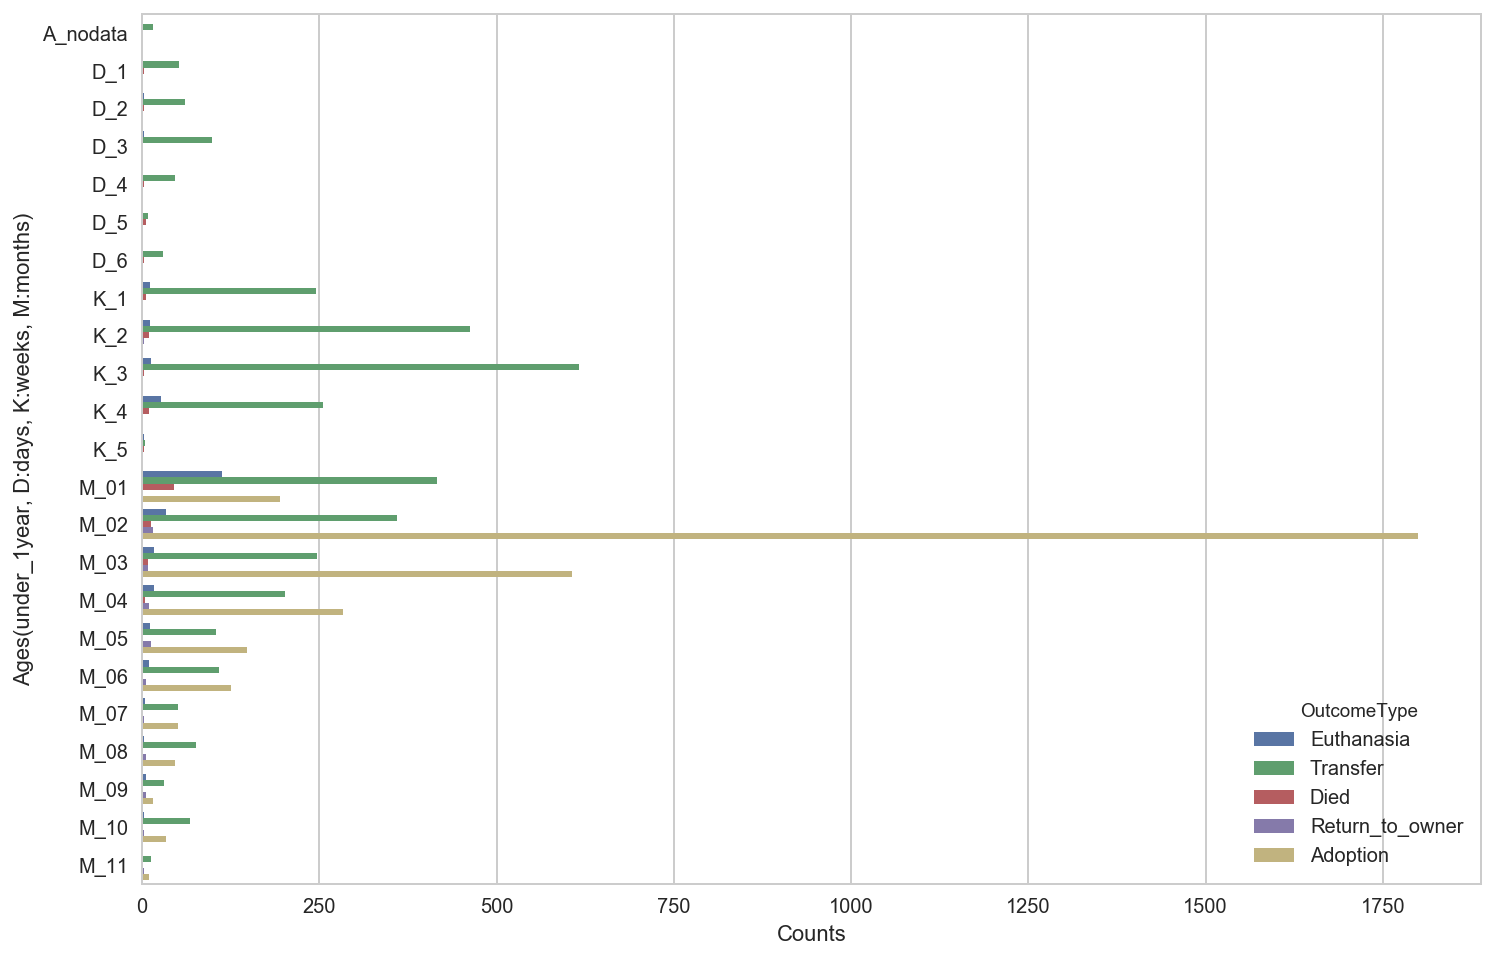

In [27]:
# 위 그래프 정제2 : 1년미만생 통계

sorted_df = df_shelter[df_shelter["Age_yscale"]!="year"].groupby(["Age_code","OutcomeType","AnimalType"]).size().reset_index(name="count")
sorted_df['Age_code'] = pd.Categorical(sorted_df['Age_code'])
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df[sorted_df["AnimalType"]=="Cat"], x="count", y="Age_code", hue="OutcomeType")
ax.set_xlabel('Counts')
ax.set_ylabel('Ages(under_1year, D:days, K:weeks, M:months)')
print("고양이의 나이별(1년미만) - 처리결과 통계")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

개의 나이별(1년미만) - 처리결과 통계


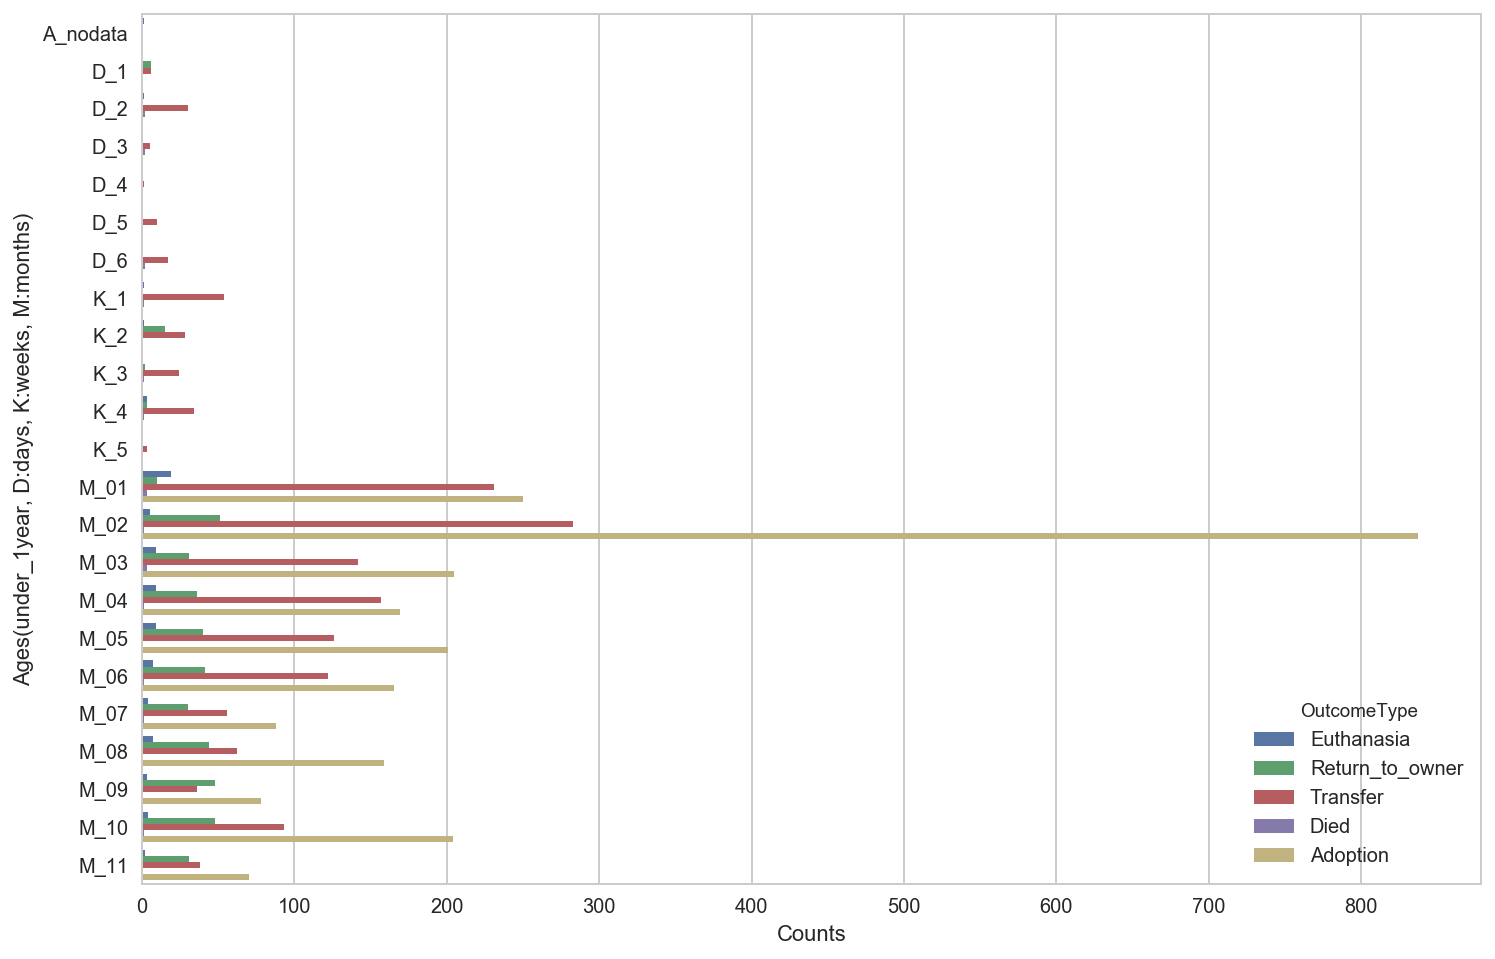

In [28]:
# 위 그래프 정제2 : 1년미만생 통계

fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df[sorted_df["AnimalType"]=="Dog"], x="count", y="Age_code", hue="OutcomeType")
ax.set_xlabel('Counts')
ax.set_ylabel('Ages(under_1year, D:days, K:weeks, M:months)')
print("개의 나이별(1년미만) - 처리결과 통계")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

## 2-3) Age - Name_exsistance

동물의 나이별(년) 개체수 통계 - 이름유무여부 그래프
0은 이름이 있음 1은 이름이 없음


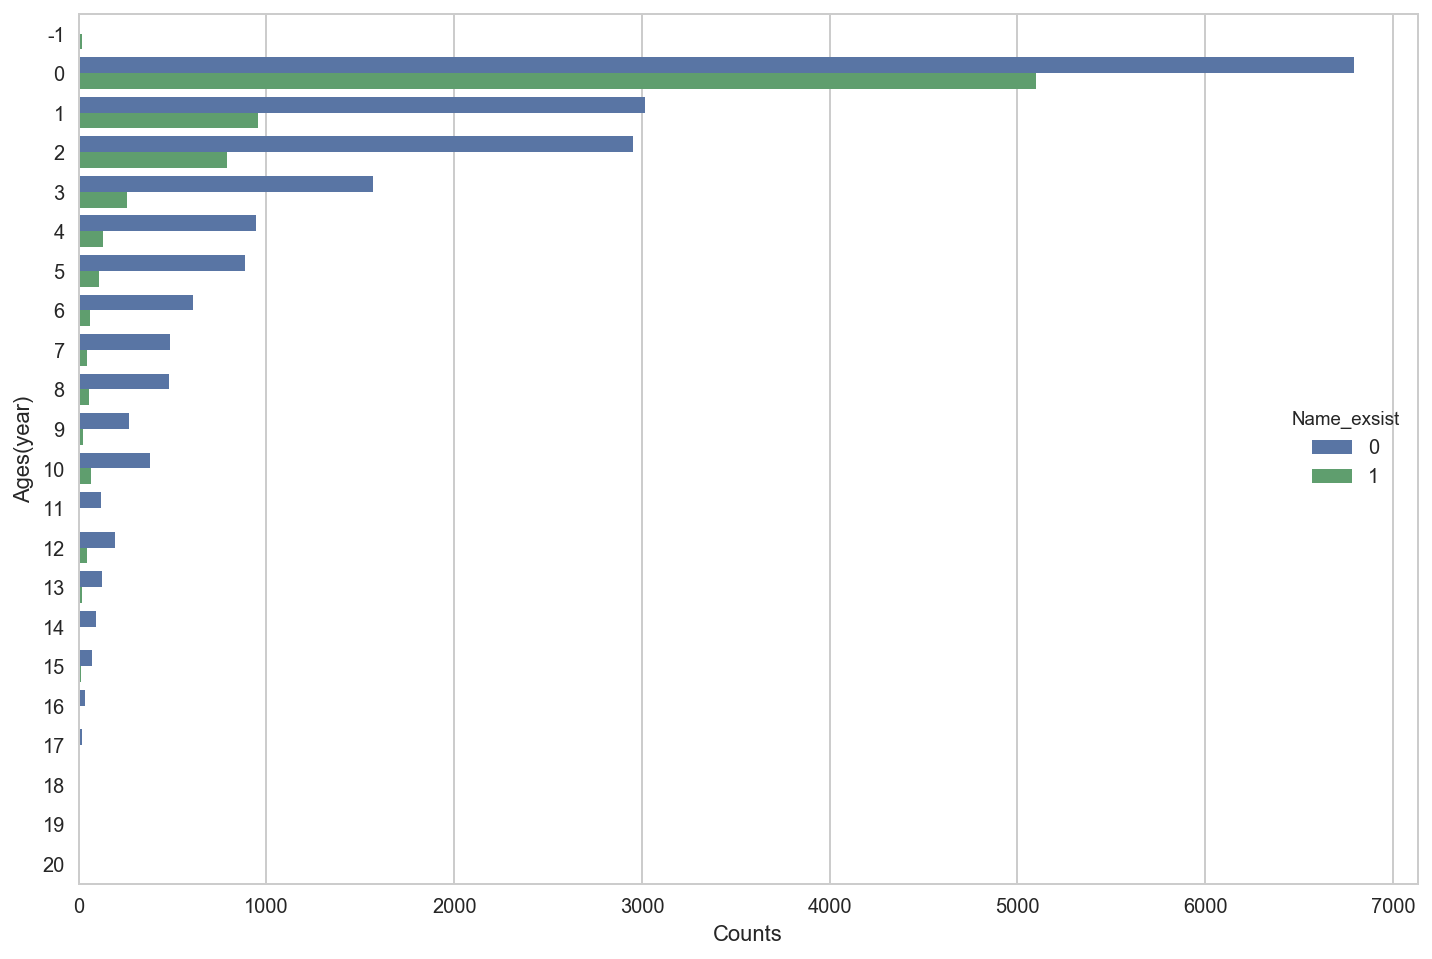

In [29]:
# 처리결과 비교 (정규화는 하지않은상태)

sorted_df = df_shelter.groupby(["Age_ynbr","Name_exsist"]).size().reset_index(name="count")
sorted_df['Age_ynbr'] = pd.Categorical(sorted_df['Age_ynbr'])
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="Age_ynbr", hue="Name_exsist")
ax.set_xlabel('Counts')
ax.set_ylabel('Ages(year)')
print("동물의 나이별(년) 개체수 통계 - 이름유무여부 그래프")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

print('0은 이름이 있음 1은 이름이 없음')

동물의 나이별(1년미만) - 이름유무여부 통계


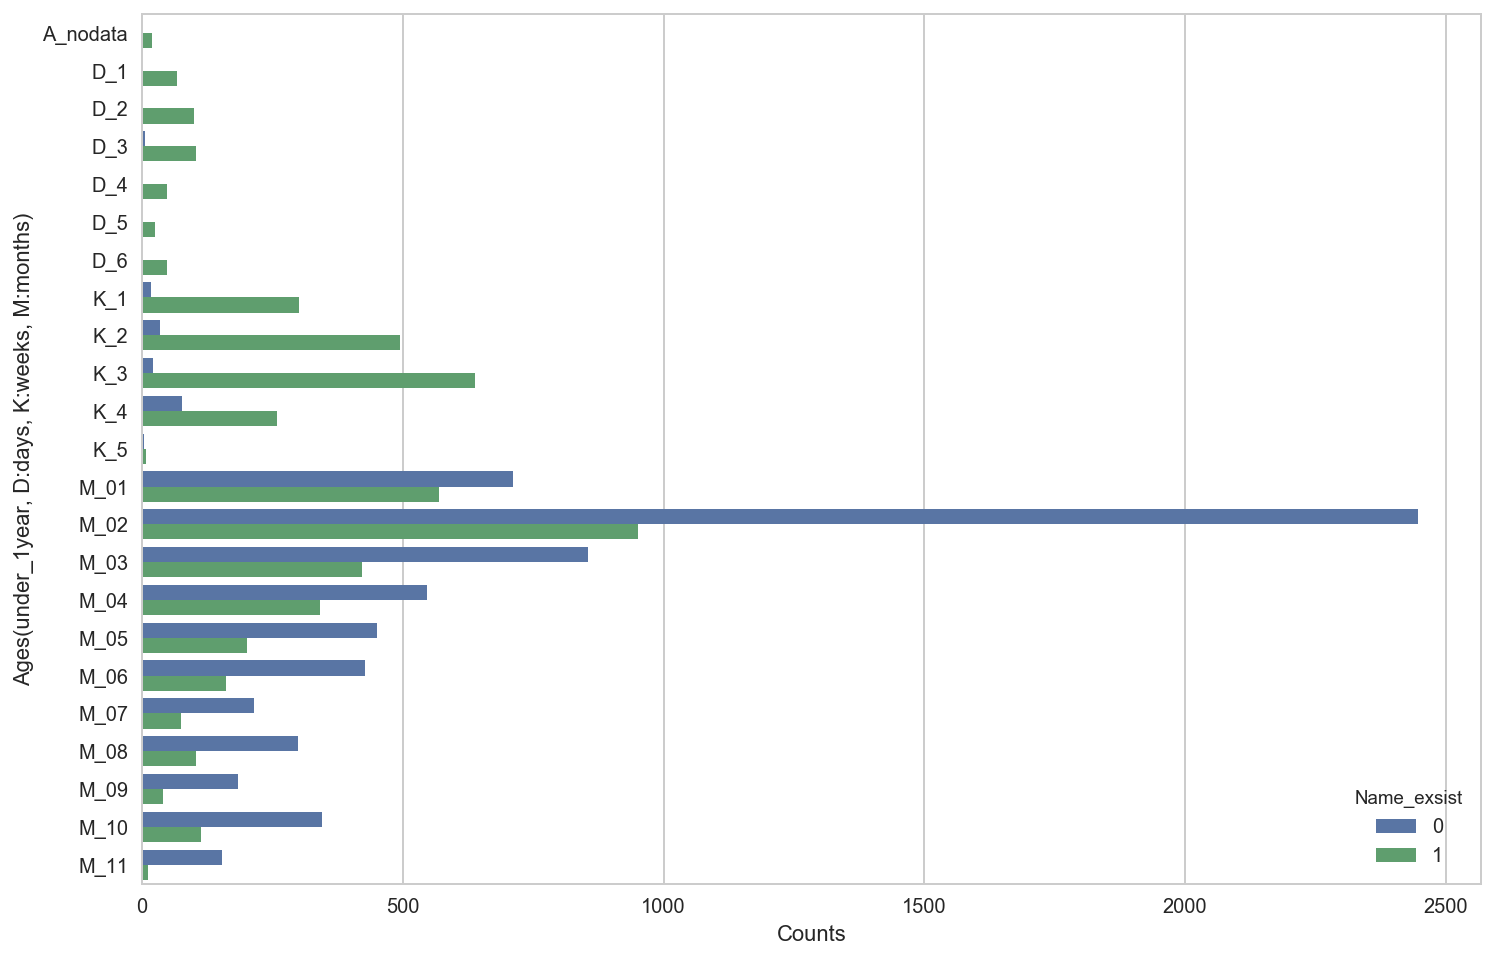

In [30]:
# 위 그래프 정제2 : 1년미만생 통계

sorted_df = df_shelter[df_shelter["Age_yscale"]!="year"].groupby(["Age_code","Name_exsist"]).size().reset_index(name="count")
sorted_df['Age_code'] = pd.Categorical(sorted_df['Age_code'])
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="Age_code", hue="Name_exsist")
ax.set_xlabel('Counts')
ax.set_ylabel('Ages(under_1year, D:days, K:weeks, M:months)')
print("동물의 나이별(1년미만) - 이름유무여부 통계")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

# Age 와 변수들 관계 결론

> **종속변수** (OutcomeType)
1. 1개월도 안된 동물의 경우는 대부분 transfer된다. (추측 - 너무 어려서 보육시설같은곳으로 가는듯)
2. 2개월된 동물의 Adoption이 가장 많다. (애교가 많고, 보육하기 어려운 시기는 거의 지났기때문인듯)
3. 나이가 많은 동물일수록 주인에게 돌아가는 경우가 많다.(길을 잃었다가 주인이 찾는 케이스인듯)
4. 1살이 안되는 어린동물은 더 나이든 동물들에 비해 죽을확률이 높다.
5. 1개월령된 동물의 안락사율이 다른 경우에 비해 매우높은편이다.

> **독립변수**
1. 동물의 나이가 많을수록 이름이 있는 경우의 비중도 점점 커진다.
2. 4개월령 미만동물의 경우 고양이가 강아지보다 많지만, 그 외에는 강아지가 고양이보다 많다.


## 2-4) OutcomeType -
##   -->OutcomeSubtype, AnimalType, SexuponOutcome

동물의 처리결과별 - 특징 통계


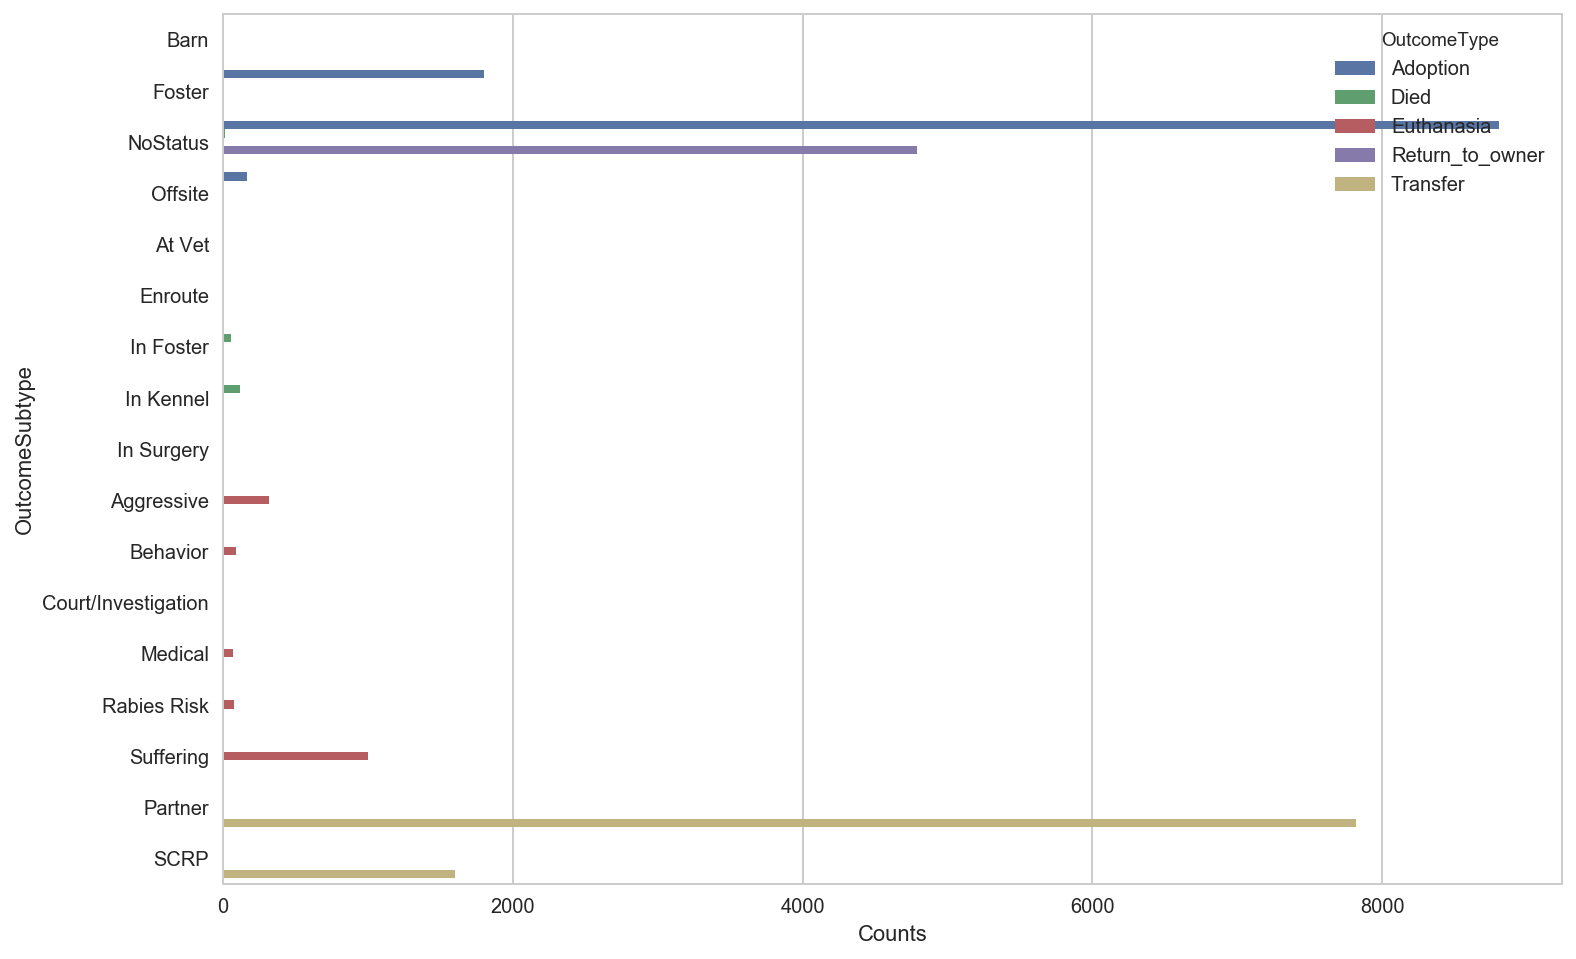

In [31]:
sorted_df = df_shelter.groupby(["OutcomeType","OutcomeSubtype"]).size().reset_index(name="count")
# sorted_df['OutcomeSybtype'] = pd.Categorical(sorted_df['OutcomeSybtype'])
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="OutcomeSubtype", hue="OutcomeType")
ax.set_xlabel('Counts')
ax.set_ylabel('OutcomeSubtype')
print("동물의 처리결과별 - 특징 통계")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

개의 처리결과별 -  성적특징 통계


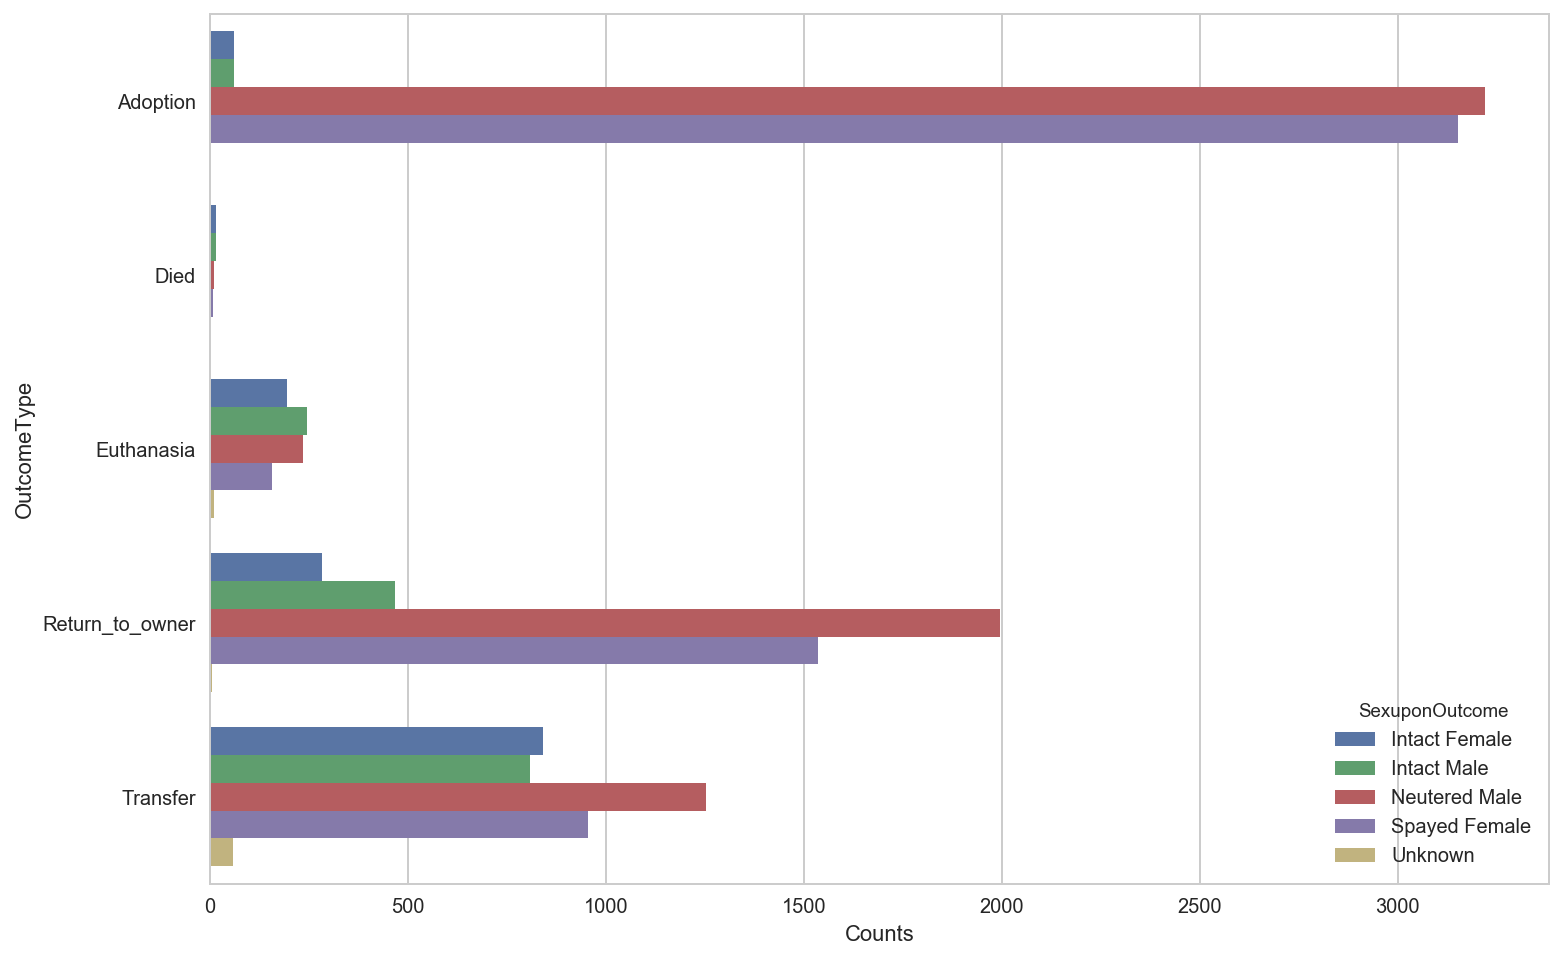

In [32]:
sorted_df = df_shelter.groupby(["OutcomeType","SexuponOutcome","AnimalType"]).size().reset_index(name="count")
# sorted_df['OutcomeSybtype'] = pd.Categorical(sorted_df['OutcomeSybtype'])
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df[sorted_df["AnimalType"]=="Dog"], x="count", y="OutcomeType", hue="SexuponOutcome")
ax.set_xlabel('Counts')
ax.set_ylabel('OutcomeType')
print("개의 처리결과별 -  성적특징 통계")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

고양이의 처리결과별 -  성적특징 통계


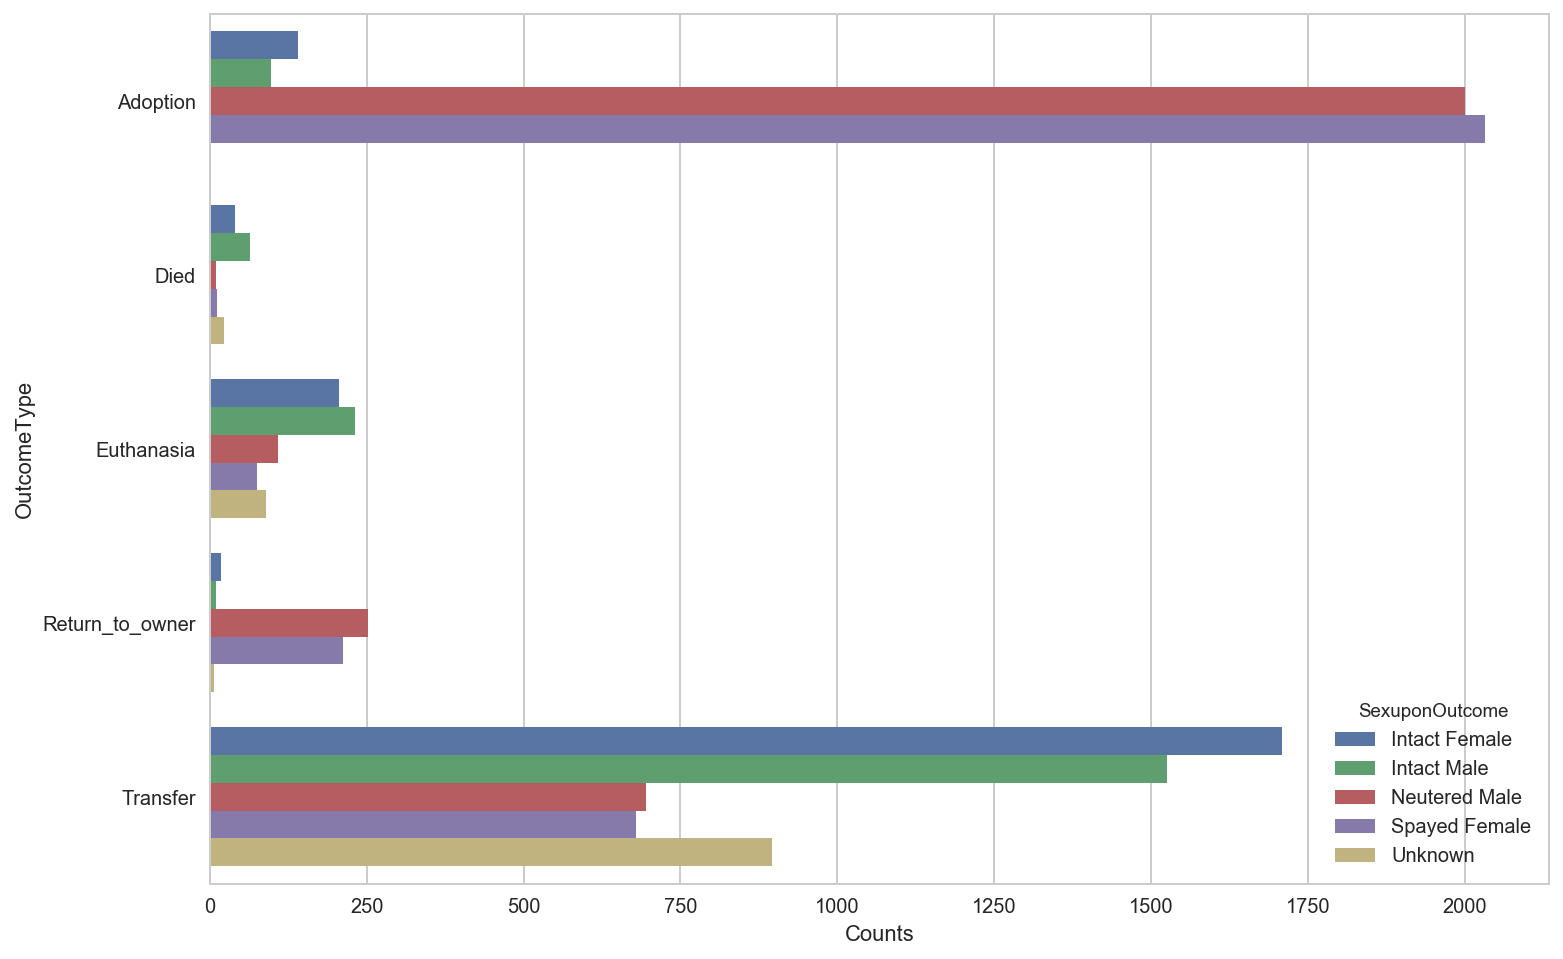

In [33]:
sorted_df = df_shelter.groupby(["OutcomeType","SexuponOutcome","AnimalType"]).size().reset_index(name="count")
# sorted_df['OutcomeSybtype'] = pd.Categorical(sorted_df['OutcomeSybtype'])
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df[sorted_df["AnimalType"]=="Cat"], x="count", y="OutcomeType", hue="SexuponOutcome")
ax.set_xlabel('Counts')
ax.set_ylabel('OutcomeType')
print("고양이의 처리결과별 -  성적특징 통계")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

동물의 처리결과별 - 종 통계


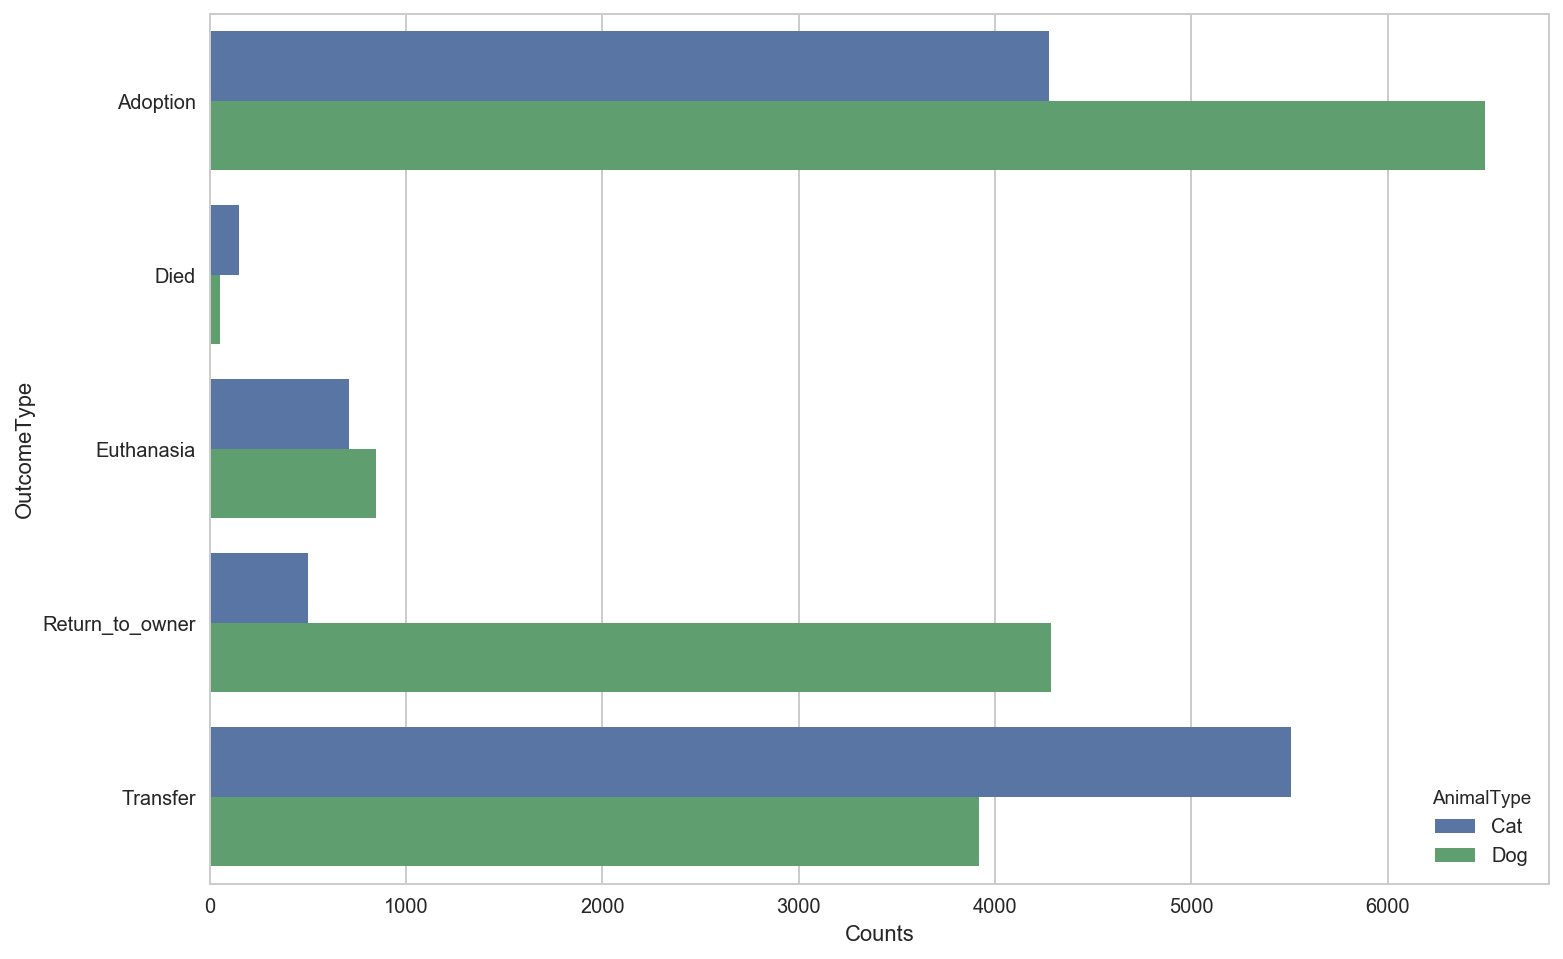

In [34]:
sorted_df = df_shelter.groupby(["OutcomeType","AnimalType"]).size().reset_index(name="count")
# sorted_df['OutcomeSybtype'] = pd.Categorical(sorted_df['OutcomeSybtype'])
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="OutcomeType", hue="AnimalType")
ax.set_xlabel('Counts')
ax.set_ylabel('OutcomeType')
print("동물의 처리결과별 - 종 통계")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

# OutcomeType 과 변수들 관계 결론

> **독립변수**
1. OutcomeType과 OutcomeSubtype사이엔 1:1 관계가 있는 클래스가 많다. (상관성이 높아서 예측시 중요한 변수가 될듯)
2. adoption은 거세된 수컷과 불임인 암컷의 비중이 높다. 주인이 있는 동물의 경우도 생식활동이 제한된 녀석들이 많다
3. 온전한 수컷,암컷은 어디론가 보내지는 경향이 있다. 그곳은 아마도... ㅜㅜ
4. 안락사 되는 동물중 성적으로 온전한 녀석들의 비중이 많은데 그 이유는 작업(?)을 하기전에 문제가 있어서 아닐까 싶다.

동물의 종 - 이름유무여부 통계


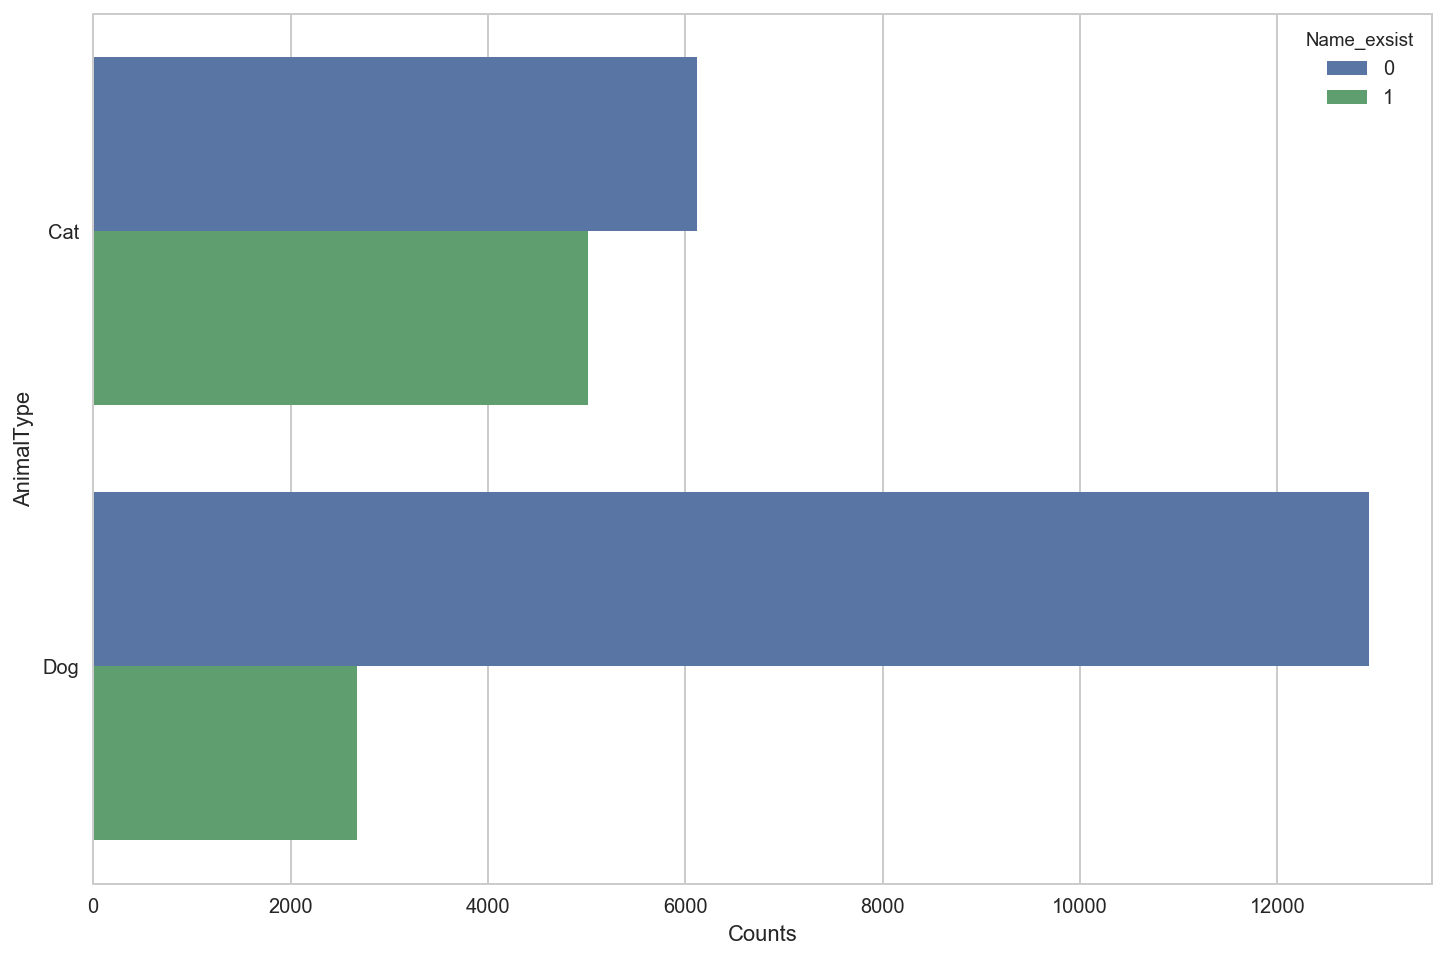

In [35]:
sorted_df = df_shelter.groupby(["Name_exsist","AnimalType"]).size().reset_index(name="count")
# sorted_df['OutcomeSybtype'] = pd.Categorical(sorted_df['OutcomeSybtype'])
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="AnimalType", hue="Name_exsist")
ax.set_xlabel('Counts')
ax.set_ylabel('AnimalType')
print("동물의 종 - 이름유무여부 통계")
# 0은 이름이 있는경우, 1은 없는경우임

동물의 종 - 이름유무여부 통계


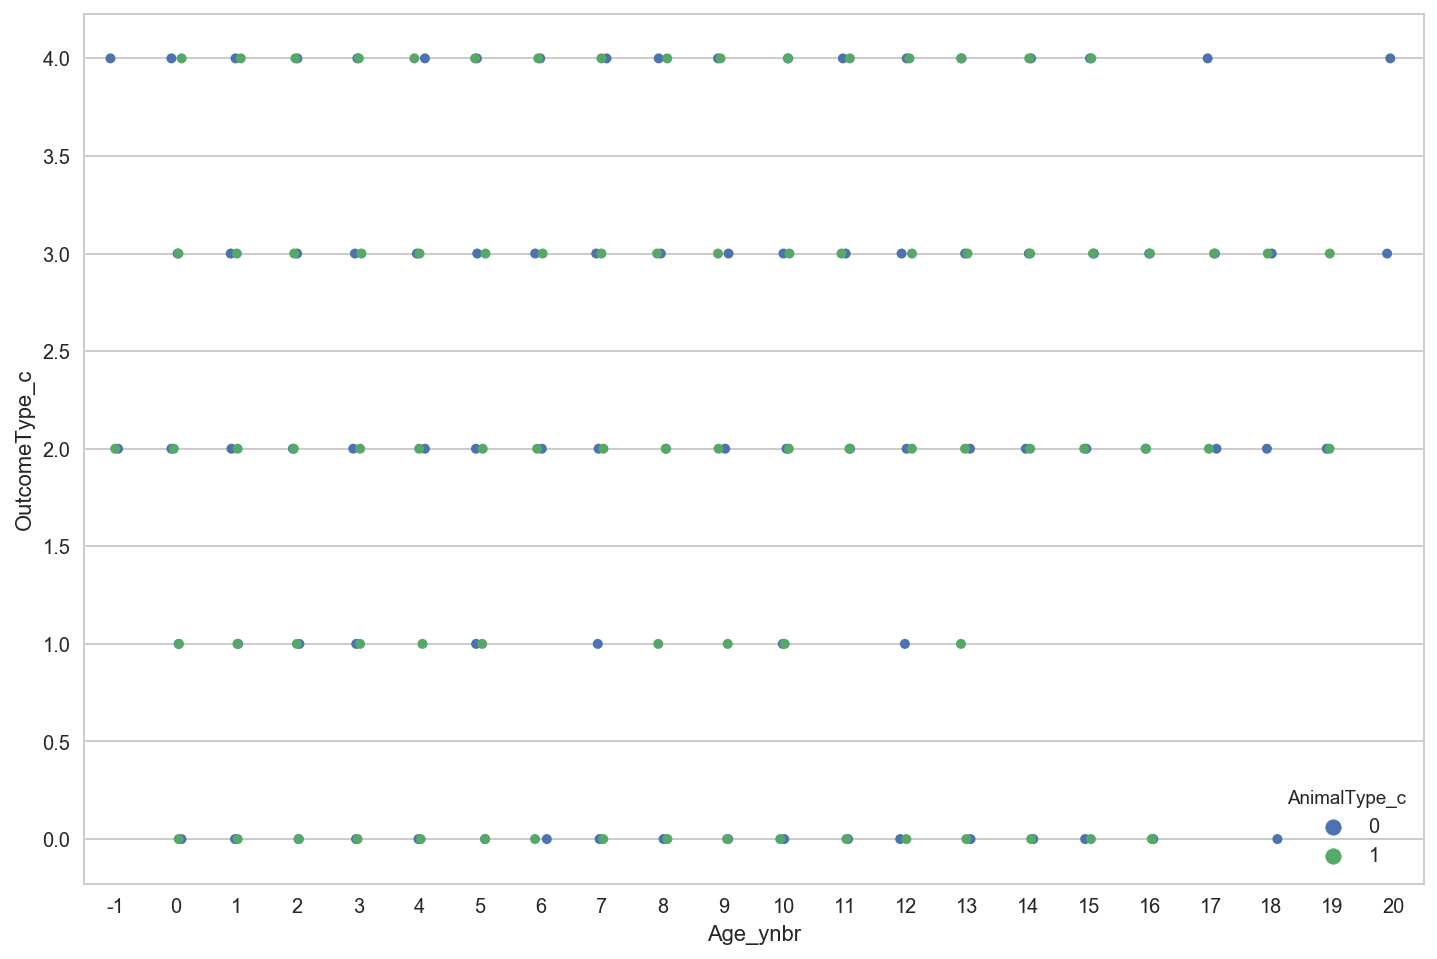

In [36]:
sorted_df = df_shelter.groupby(["AnimalType_c","OutcomeType_c","Age_ynbr"]).size().reset_index(name="count")
# sorted_df['OutcomeSybtype'] = pd.Categorical(sorted_df['OutcomeSybtype'])
# sorted_df["AT_code"] = 0
# sorted_df.AT_code[sorted_df["AnimalType"]=='Dog'] = 1
fig = plt.figure(figsize=(12,8))
# ax = sns.stripplot(data = sorted_df, x="Age_ynbr", y="OutcomeType_c", hue="AnimalType_c", jitter=True, scatter_kws={'s':np.log(sorted_df["count"])*30})
ax = sns.stripplot(data = sorted_df, x="Age_ynbr", y="OutcomeType_c", hue="AnimalType_c", jitter=True)
# ax.set_xlabel('Counts')
# ax.set_ylabel('AnimalType')
print("동물의 종 - 이름유무여부 통계")
# 0은 이름이 있는경우, 1은 없는경우임

# 모델링 - 로지스틱 회귀분석

---
# Adoption Modeling - Logistic

In [37]:
# model = sm.Logit.from_formula("Return_b ~ Name_exsist + AnimalType_c + Male_b + intact_b + sex_unknown + Breed_Mix + Breed_Domestic + Breed_Lhair + Breed_Shair + Age_ynbr", df_shelter)
model = sm.Logit.from_formula("Adoption_b ~ Name_exsist + AnimalType_c + Age_ynbr + Male_b + intact_b + Breed_Domestic", df_shelter)
resultL1 = model.fit(disp=0)
print(resultL1.summary())

                           Logit Regression Results                           
Dep. Variable:             Adoption_b   No. Observations:                26729
Model:                          Logit   Df Residuals:                    26722
Method:                           MLE   Df Model:                            6
Date:                Wed, 01 Aug 2018   Pseudo R-squ.:                  0.2273
Time:                        15:32:18   Log-Likelihood:                -13924.
converged:                       True   LL-Null:                       -18020.
                                        LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.4277      0.095     15.014      0.000       1.241       1.614
Name_exsist       -0.9268      0.038    -24.401      0.000      -1.001      -0.852
AnimalType_c      -0.7107      0.094

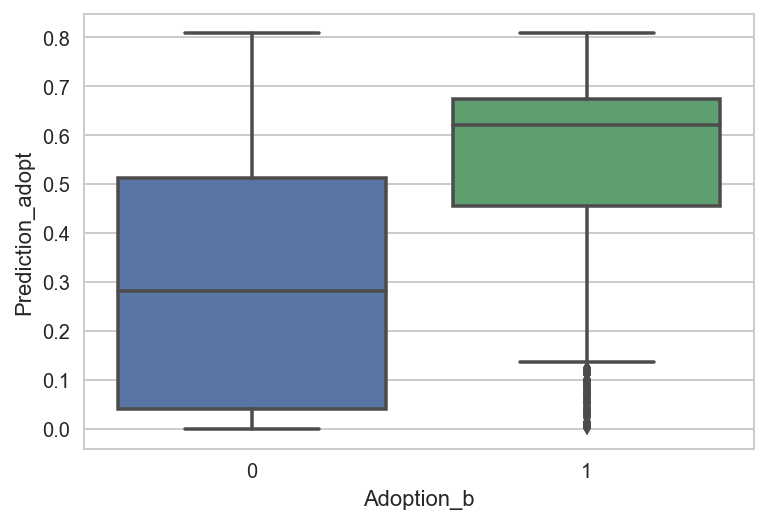

In [38]:
df_shelter["Prediction_adopt"] = resultL1.predict(df_shelter)
sns.boxplot(x="Adoption_b", y="Prediction_adopt", data=df_shelter)
plt.show()

In [39]:
#classifycation report
from sklearn.metrics import *

y_true = df_shelter["Adoption_b"]
y_pred = (df_shelter["Prediction_adopt"]>0.4)
target_names = ['0/not Adopted', '1/Adopted']
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=target_names))

[[9250 6710]
 [1644 9125]]
               precision    recall  f1-score   support

0/not Adopted       0.85      0.58      0.69     15960
    1/Adopted       0.58      0.85      0.69     10769

  avg / total       0.74      0.69      0.69     26729



# Euthanasia Modeling - Logistic

In [40]:
# model = sm.Logit.from_formula("Return_b ~ Name_exsist + AnimalType_c + Male_b + intact_b + sex_unknown + Breed_Mix + Breed_Domestic + Breed_Lhair + Breed_Shair + Age_ynbr", df_shelter)
model = sm.Logit.from_formula("Euthanasia_b ~ Age_tscale + Name_exsist + Age_ynbr + Male_b + intact_b + sex_unknown", df_shelter)
resultL2 = model.fit(disp=0)
print(resultL2.summary())

                           Logit Regression Results                           
Dep. Variable:           Euthanasia_b   No. Observations:                26729
Model:                          Logit   Df Residuals:                    26719
Method:                           MLE   Df Model:                            9
Date:                Wed, 01 Aug 2018   Pseudo R-squ.:                  0.1729
Time:                        15:32:20   Log-Likelihood:                -4906.4
converged:                       True   LL-Null:                       -5931.7
                                        LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -6.8829      0.392    -17.548      0.000      -7.652      -6.114
Age_tscale[T.month]      1.8782      0.389      4.826      0.000       1.115       2.641
Age_tscale[T

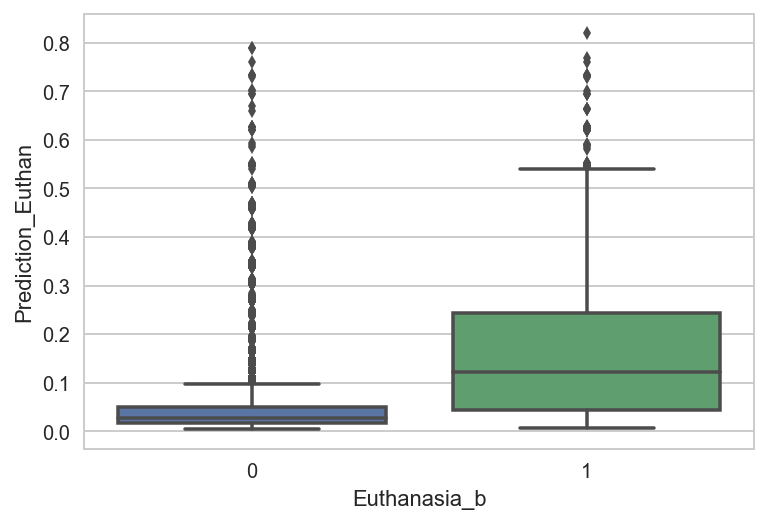

In [41]:
df_shelter["Prediction_Euthan"] = resultL2.predict(df_shelter)
sns.boxplot(x="Euthanasia_b", y="Prediction_Euthan", data=df_shelter)
plt.show()

In [42]:
#confusion_matrix and classifycation report
from sklearn.metrics import *

y_true = df_shelter["Euthanasia_b"]
y_pred = (df_shelter["Prediction_Euthan"]>0.06)
target_names = ['0/not_Euthanasia', '1/Euthanasia']
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=target_names))

[[19574  5600]
 [  490  1065]]
                  precision    recall  f1-score   support

0/not_Euthanasia       0.98      0.78      0.87     25174
    1/Euthanasia       0.16      0.68      0.26      1555

     avg / total       0.93      0.77      0.83     26729



# Return to owner Modeling - Logistic

In [43]:
model = sm.Logit.from_formula("Return_b ~ Name_exsist + AnimalType_c + Age_ynbr + Male_b", df_shelter)
resultL3 = model.fit(disp=0)
print(resultL3.summary())

                           Logit Regression Results                           
Dep. Variable:               Return_b   No. Observations:                26729
Model:                          Logit   Df Residuals:                    26724
Method:                           MLE   Df Model:                            4
Date:                Wed, 01 Aug 2018   Pseudo R-squ.:                  0.2123
Time:                        15:32:22   Log-Likelihood:                -9894.2
converged:                       True   LL-Null:                       -12562.
                                        LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.0274      0.054    -55.664      0.000      -3.134      -2.921
Name_exsist     -2.1656      0.085    -25.371      0.000      -2.333      -1.998
AnimalType_c     1.6351      0.051     31.82

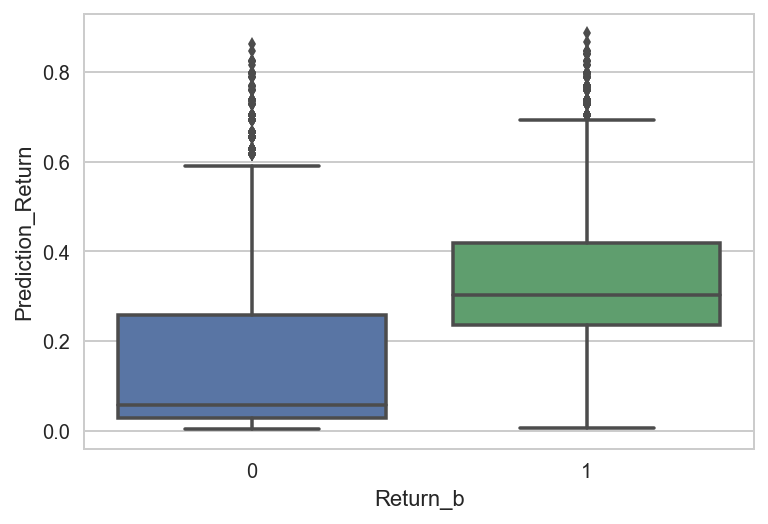

In [44]:
df_shelter["Prediction_Return"] = resultL3.predict(df_shelter)
sns.boxplot(x="Return_b", y="Prediction_Return", data=df_shelter)
plt.show()

In [45]:
#confusion_matrix and classifycation report
from sklearn.metrics import *
y_true = df_shelter["Return_b"]
y_pred = (df_shelter["Prediction_Return"]>0.22)
target_names = ['0/not return', '1/Return to owner']
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=target_names))

[[14283  7660]
 [  721  4065]]
                   precision    recall  f1-score   support

     0/not return       0.95      0.65      0.77     21943
1/Return to owner       0.35      0.85      0.49      4786

      avg / total       0.84      0.69      0.72     26729



# Transfer Modeling- Logistic

In [46]:
model = sm.Logit.from_formula("Transfer_b ~ Age_tscale + Name_exsist + AnimalType_c + intact_b + sex_unknown + Age_ynbr + 0", df_shelter)
resultL4 = model.fit(disp=0)
print(resultL4.summary())

                           Logit Regression Results                           
Dep. Variable:             Transfer_b   No. Observations:                26729
Model:                          Logit   Df Residuals:                    26719
Method:                           MLE   Df Model:                            9
Date:                Wed, 01 Aug 2018   Pseudo R-squ.:                  0.2437
Time:                        15:32:23   Log-Likelihood:                -13118.
converged:                       True   LL-Null:                       -17347.
                                        LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Age_tscale[day]        0.0184      0.187      0.099      0.921      -0.348       0.385
Age_tscale[month]     -1.4117      0.033    -42.429      0.000      -1.477      -1.347
Age_tscale[nodata]  

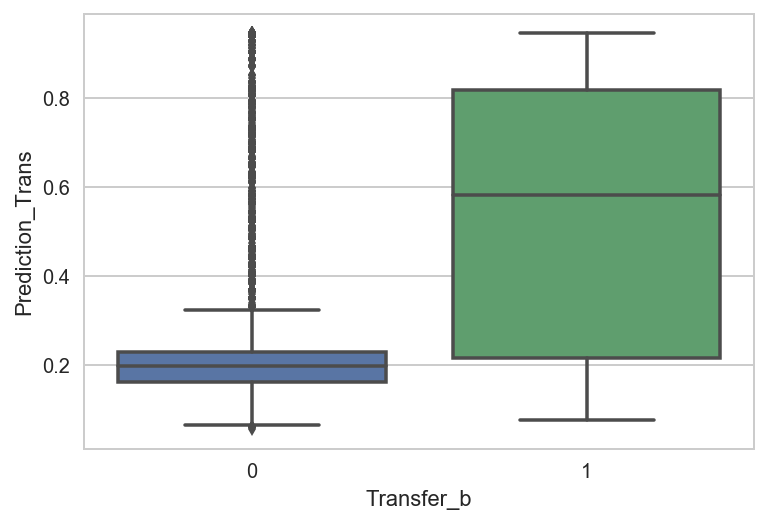

In [47]:
df_shelter["Prediction_Trans"] = resultL4.predict(df_shelter)
sns.boxplot(x="Transfer_b", y="Prediction_Trans", data=df_shelter)
plt.show()

In [48]:
#confusion_matrix and classifycation report
from sklearn.metrics import *
y_true = df_shelter["Transfer_b"]
y_pred = (df_shelter["Prediction_Trans"]>0.27)
target_names = ['0/not Transfer', '1/Transfer']
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=target_names))

[[13341  3966]
 [ 2733  6689]]
                precision    recall  f1-score   support

0/not Transfer       0.83      0.77      0.80     17307
    1/Transfer       0.63      0.71      0.67      9422

   avg / total       0.76      0.75      0.75     26729



# Died - Logistic

In [49]:
model = sm.Logit.from_formula("Died_b ~ AnimalType_c + Breed_Domestic + Breed_Lhair + Breed_Shair + Male_b + intact_b + sex_unknown", df_shelter)
resultL5 = model.fit(disp=0)
print(resultL5.summary())

                           Logit Regression Results                           
Dep. Variable:                 Died_b   No. Observations:                26729
Model:                          Logit   Df Residuals:                    26721
Method:                           MLE   Df Model:                            7
Date:                Wed, 01 Aug 2018   Pseudo R-squ.:                  0.1120
Time:                        15:32:25   Log-Likelihood:                -1033.3
converged:                       True   LL-Null:                       -1163.6
                                        LLR p-value:                 1.490e-52
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.8426      0.395    -14.797      0.000      -6.617      -5.069
AnimalType_c      -1.0276      0.390     -2.636      0.008      -1.792      -0.264
Breed_Domestic    -0.4086      0.433

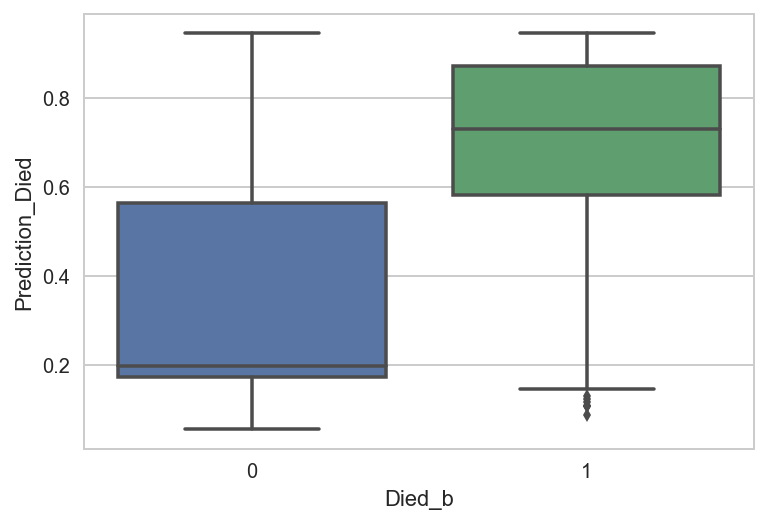

In [50]:
df_shelter["Prediction_Died"] = resultL4.predict(df_shelter)
sns.boxplot(x="Died_b", y="Prediction_Died", data=df_shelter)
plt.show()

In [51]:
#confusion_matrix and classifycation report
from sklearn.metrics import *
y_true = df_shelter["Died_b"]
y_pred = (df_shelter["Prediction_Died"]>0.58)
target_names = ['0/not died', '1/Dead']
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=target_names))

[[20207  6325]
 [   43   154]]
             precision    recall  f1-score   support

 0/not died       1.00      0.76      0.86     26532
     1/Dead       0.02      0.78      0.05       197

avg / total       0.99      0.76      0.86     26729



# 모델링 - 나이브베이즈모형
---

# 1. Naive Bayes 용 df-np전처리

In [56]:
# 1차 기본정제

# 'Name_exsist', 'Age_nbr', 'Age_tscale', 'Age_yscale', 'Age_ynbr', 'Age_code', 'intact_b', 'sex_unknown', 'Male_b', 'Survived', 'Euthanasia_b', 'Transfer_b', 'Adoption_b', 'Died_b', 'Return_b', 'OutcomeType_c', 'OutcomeSubtype_c', 'AnimalType_c', 'SexuponOutcome_c', 'Breed_c', 'Color_c', 'Breed_normal', 'Breed_Domestic', 'Breed_Mix', 'Breed_Lhair', 'Breed_Shair'
df_for_Naive = df_shelter[['OutcomeType_c', 'Name_exsist', 'Age_nbr', 'Age_tscale', 'Age_yscale', 'Age_ynbr', 'AnimalType_c', 'SexuponOutcome_c', 'Breed_Domestic', 'Breed_Mix', 'Breed_Lhair', 'Breed_Shair', "Time_DOF", "Time_day", "Time_month", "Time_hour"]]

ATc = LabelEncoder()
y = df_for_Naive["Age_tscale"]
ATc.fit(y)
df_for_Naive["Age_tscale"] = ATc.transform(y)

AYc = LabelEncoder()
y = df_for_Naive["Age_yscale"]
AYc.fit(y)
df_for_Naive["Age_yscale"] = AYc.transform(y)

df_for_Naive.tail(3)


C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,OutcomeType_c,Name_exsist,Age_nbr,Age_tscale,Age_yscale,Age_ynbr,AnimalType_c,SexuponOutcome_c,Breed_Domestic,Breed_Mix,Breed_Lhair,Breed_Shair,Time_DOF,Time_day,Time_month,Time_hour
26726,0,0,4,4,2,4,1,2,0,1,0,0,0,9,3,13
26727,4,1,4,3,1,0,0,1,1,1,0,1,6,27,4,12
26728,4,1,1,4,2,1,0,1,1,1,0,1,3,2,7,9


In [57]:
# -1 값이 있으므로 바꿔주는 작업이 필요하다.
df_for_Naive.Age_nbr[df_for_Naive["Age_nbr"] == -1] = 0
df_for_Naive.Age_ynbr[df_for_Naive["Age_ynbr"] == -1] = 0

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\creal\Anaconda3\lib\site-packages\pandas\core\generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\creal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\creal\Anaconda3\lib\site-packages\ipyke

In [58]:
# 2차 df -> np정제후 데이터 만들기

def getNpTarget1d(df, target_col_name, ls=[]):
    target_df = df[target_col_name].values
    return target_df

def getNpData1d(df, target_col_name = None, ls=[]):
    data_df = df[ls].values
    return data_df

ls = list(df_for_Naive.columns.values[1:])

df_target = getNpTarget1d(df_for_Naive,"OutcomeType_c",ls) 
df_data = getNpData1d(df_for_Naive,"OutcomType_c",ls) 

In [59]:
df_data

array([[ 0,  1,  4, ..., 12,  2, 18],
       [ 0,  1,  4, ..., 13, 10, 12],
       [ 0,  2,  4, ..., 31,  1, 12],
       ..., 
       [ 0,  4,  4, ...,  9,  3, 13],
       [ 1,  4,  3, ..., 27,  4, 12],
       [ 1,  1,  4, ...,  2,  7,  9]], dtype=int64)

# Modeling - Multinomial Naive Bayes 

In [60]:
from sklearn.naive_bayes import MultinomialNB
model_mult = MultinomialNB().fit(df_data,df_target)

In [61]:
result_mult = model_mult.predict(df_data)

In [62]:
model_mult.classes_

array([0, 1, 2, 3, 4], dtype=int64)

In [63]:
model_mult.class_count_

array([ 10769.,    197.,   1555.,   4786.,   9422.])

In [64]:
np.exp(model_mult.class_log_prior_)

array([ 0.40289573,  0.00737027,  0.05817651,  0.17905646,  0.35250103])

In [65]:
# confusion matrix
from sklearn.metrics import confusion_matrix
# y_true = dfnew["species_c"]
# y_pred = (dfnew["Prediction"]>0.5)
confusion_matrix(df_target,result_mult)

array([[6851,    0,  167, 1714, 2037],
       [  38,    0,   10,   13,  136],
       [ 215,    0,  264,  410,  666],
       [1742,    0,   91, 2494,  459],
       [2392,    0,  303, 1145, 5582]], dtype=int64)

In [66]:
#classifycation report
from sklearn.metrics import *

print(classification_report(df_target, result_mult, target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))

                 precision    recall  f1-score   support

       Adoption       0.61      0.64      0.62     10769
           Died       0.00      0.00      0.00       197
     Euthanasia       0.32      0.17      0.22      1555
Return_to_owner       0.43      0.52      0.47      4786
       Transfer       0.63      0.59      0.61      9422

    avg / total       0.56      0.57      0.56     26729



C:\Users\creal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 의사결정나무 모델링

In [67]:
# 2차 df -> np정제후 데이터 만들기

#(개:1)냐 (고양이:0)냐 선택 
df_temp = df_for_Naive[df_for_Naive["AnimalType_c"]!=2]

def getNpTarget1d(df, target_col_name, ls=[]):
    target_df = df[target_col_name].values
    return target_df

def getNpData1d(df, target_col_name = None, ls=[]):
    data_df = df[ls].values
    return data_df

ls = list(df_for_Naive.columns.values[1:])

df_target = getNpTarget1d(df_temp,"OutcomeType_c",ls) 
df_data = getNpData1d(df_temp,"OutcomType_c",ls)
len(df_target)

26729

In [68]:
import io
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

def draw_decision_tree(model):
    dot_buf = io.StringIO() 
    export_graphviz(model, out_file=dot_buf, feature_names=['Name_exsist', 'Age_nbr','Age_tscale', 'Age_yscale', 'Age_ynbr', 'AnimalType_c'])#["Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)

# 2차원 플롯화
# def plot_decision_regions(X, y, model, title):
#     resolution = 0.01
#     markers = ('s', '^', 'o')
#     colors = ('red', 'blue', 'lightgreen')
#     cmap = mpl.colors.ListedColormap(colors[:len(np.unique(y))])
    
#     x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
#     Z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
    
#     plt.contour(xx1, xx2, Z, cmap=mpl.colors.ListedColormap(['k']))
#     plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
#     plt.xlim(xx1.min(), xx1.max())
#     plt.ylim(xx2.min(), xx2.max())

#     for idx, cl in enumerate(np.unique(y)):
#         plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], s=80, label=cl)

# #     plt.xlabel(iris.feature_names[2])
# #     plt.ylabel(iris.feature_names[3])
#     plt.legend(loc='upper left')
#     plt.title(title)
    
#     return Z
# df_for_Naive.columns

In [69]:
from sklearn.tree import DecisionTreeClassifier

tree_sample = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=0).fit(df_data.T[1:7].T,df_target)
tree1 = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0).fit(df_data,df_target)
tree2 = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=0).fit(df_data,df_target)
tree3 = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0).fit(df_data,df_target)
tree4 = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0).fit(df_data,df_target)
tree5 = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0).fit(df_data,df_target)

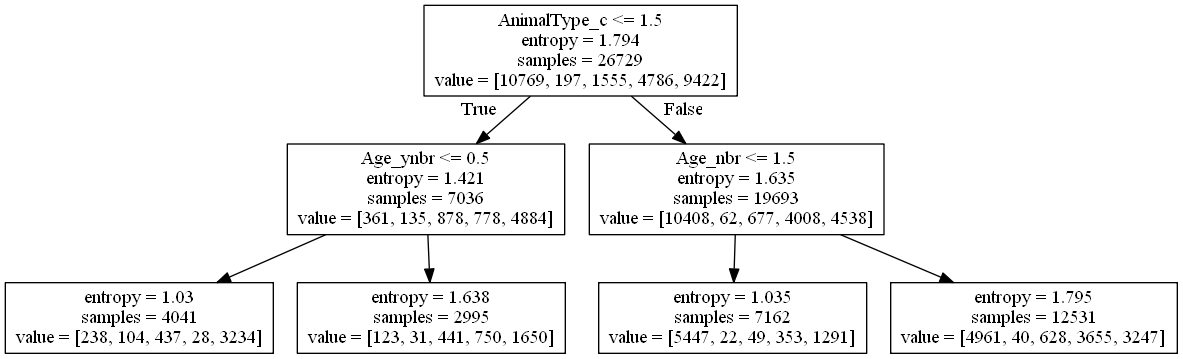

In [70]:
# 트리가 안뜨로 에러뜨면 아래 링크 참조해서 따라하고 깔자
# https://stackoverflow.com/questions/40632486/dot-exe-not-found-in-path-pydot-on-python-windows-7
# https://www.codesofinterest.com/2017/02/visualizing-model-structures-in-keras.html

import os
os.environ["PATH"] += os.pathsep + 'C:/Users/creal/graphviz-2.38/release/bin'

draw_decision_tree(tree_sample)

In [71]:
df_data[0]

array([ 0,  1,  4,  2,  1,  1,  2,  0,  1,  0,  0,  2, 12,  2, 18], dtype=int64)

In [72]:
# plot_decision_regions(df_data,df_target, tree1, "Depth 1")
# plt.show()
treeA = DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=0).fit(df_data,df_target)

from sklearn.metrics import *
print("- Accuracy_Score : ", accuracy_score(df_target,treeA.predict(df_data)))
print("- Confusion_Matrix \n",confusion_matrix(df_target, treeA.predict(df_data)))
print(classification_report(df_target, treeA.predict(df_data), target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))

- Accuracy_Score :  0.6690485989
- Confusion_Matrix 
 [[8991    8    2 1088  680]
 [  21   34    6    7  129]
 [ 238   12  221  259  825]
 [2019    1   13 1976  777]
 [2016   10   67  668 6661]]
                 precision    recall  f1-score   support

       Adoption       0.68      0.83      0.75     10769
           Died       0.52      0.17      0.26       197
     Euthanasia       0.72      0.14      0.24      1555
Return_to_owner       0.49      0.41      0.45      4786
       Transfer       0.73      0.71      0.72      9422

    avg / total       0.67      0.67      0.65     26729



### 의사결정나무 - CV결과

Tree Model1: Mean score: 0.572 --- acuraccy score : 0.572
Tree Model2: Mean score: 0.572 --- acuraccy score : 0.572
Tree Model3: Mean score: 0.609 --- acuraccy score : 0.609
Tree Model4: Mean score: 0.616 --- acuraccy score : 0.617
Tree Model5: Mean score: 0.630 --- acuraccy score : 0.637
Tree Model6: Mean score: 0.651 --- acuraccy score : 0.655
Tree Model7: Mean score: 0.662 --- acuraccy score : 0.669
Tree Model8: Mean score: 0.668 --- acuraccy score : 0.679
Tree Model9: Mean score: 0.668 --- acuraccy score : 0.688
Tree Model10: Mean score: 0.664 --- acuraccy score : 0.701
Tree Model11: Mean score: 0.659 --- acuraccy score : 0.717
Tree Model12: Mean score: 0.655 --- acuraccy score : 0.739
Tree Model13: Mean score: 0.649 --- acuraccy score : 0.764
Tree Model14: Mean score: 0.643 --- acuraccy score : 0.789
Tree Model15: Mean score: 0.638 --- acuraccy score : 0.817


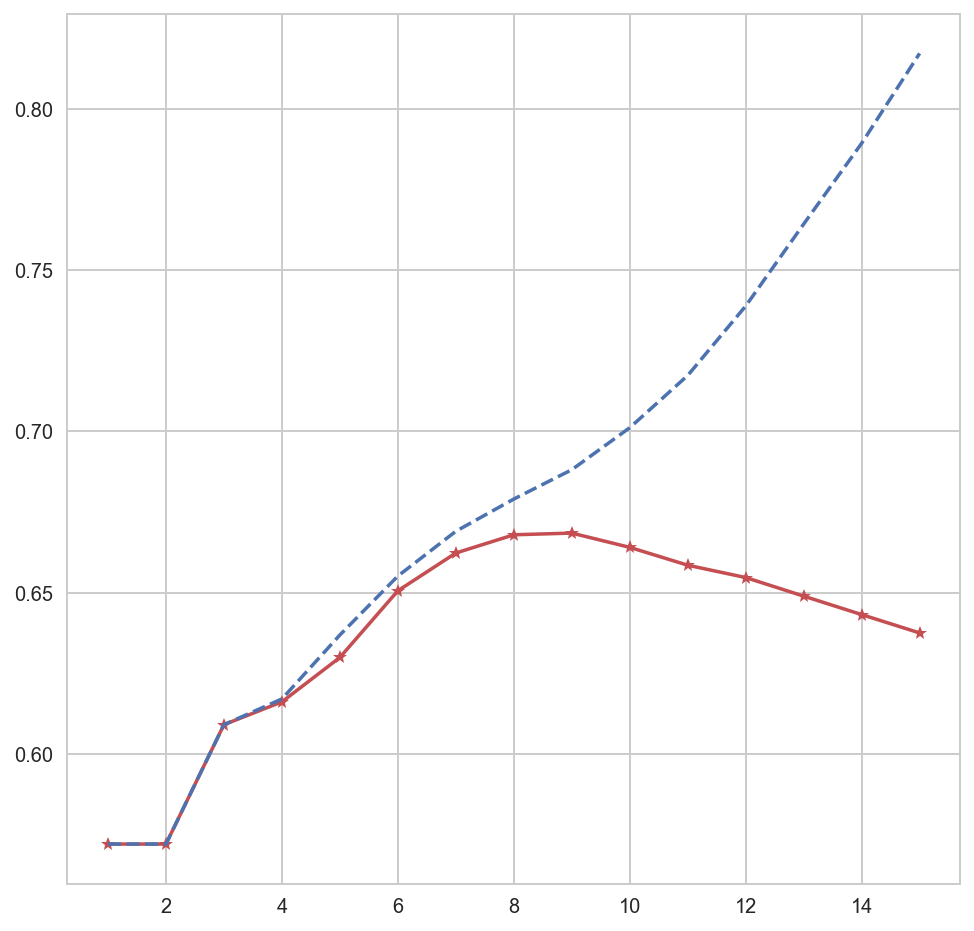

In [73]:
from sklearn.model_selection import cross_val_score, KFold
tree_ls = []
score_ls = []
accur_ls = []

# tree 모델 자동생성 반복문
for i in range(1,16):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=0).fit(df_data,df_target)
    tree_ls.append(tree)

# 모델 CV돌리기
for i, model in enumerate(tree_ls):
    scores = cross_val_score(model, df_data, df_target,cv=10)
    accuracy = accuracy_score(df_target,model.predict(df_data))
    print(("Tree Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

# Gradient Boosting

In [75]:
from sklearn.ensemble import GradientBoostingClassifier

model_grad = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=0).fit(df_data,df_target)


In [76]:
from sklearn.metrics import *
print("- Accuracy_Score : ", accuracy_score(df_target,model_grad.predict(df_data)))
print("- Confusion_Matrix \n",confusion_matrix(df_target, model_grad.predict(df_data)))
print(classification_report(df_target, model_grad.predict(df_data), target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))

- Accuracy_Score :  0.687717460436
- Confusion_Matrix 
 [[9129    0   16  991  633]
 [  19   22    8   12  136]
 [ 210    4  259  320  762]
 [1862    0   14 2317  593]
 [1838    1  106  822 6655]]
                 precision    recall  f1-score   support

       Adoption       0.70      0.85      0.77     10769
           Died       0.81      0.11      0.20       197
     Euthanasia       0.64      0.17      0.26      1555
Return_to_owner       0.52      0.48      0.50      4786
       Transfer       0.76      0.71      0.73      9422

    avg / total       0.69      0.69      0.67     26729



array([ 0.06028075,  0.07697008,  0.0730451 ,  0.00804045,  0.1212068 ,
        0.04769169,  0.1121887 ,  0.01735424,  0.01185912,  0.00795127,
        0.0206544 ,  0.06793067,  0.07952917,  0.06202802,  0.23326955])

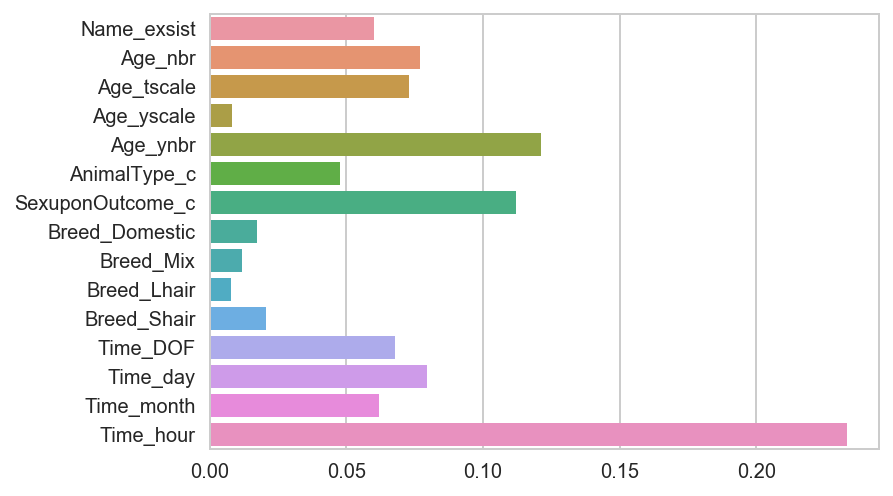

In [77]:
# 피쳐 중요도
importance = model_grad.feature_importances_
sns.barplot(y=df_for_Naive.columns[1:], x=importance)
importance

model creating.., 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
model testing...
Tree Model1: Mean score: 0.660 --- acuraccy score : 0.661
Tree Model2: Mean score: 0.675 --- acuraccy score : 0.677
Tree Model3: Mean score: 0.680 --- acuraccy score : 0.688
Tree Model4: Mean score: 0.682 --- acuraccy score : 0.700
Tree Model5: Mean score: 0.686 --- acuraccy score : 0.721
Tree Model6: Mean score: 0.685 --- acuraccy score : 0.756
Tree Model7: Mean score: 0.685 --- acuraccy score : 0.802
Tree Model8: Mean score: 0.686 --- acuraccy score : 0.863
Tree Model9: Mean score: 0.683 --- acuraccy score : 0.933
Tree Model10: Mean score: 0.682 --- acuraccy score : 0.979


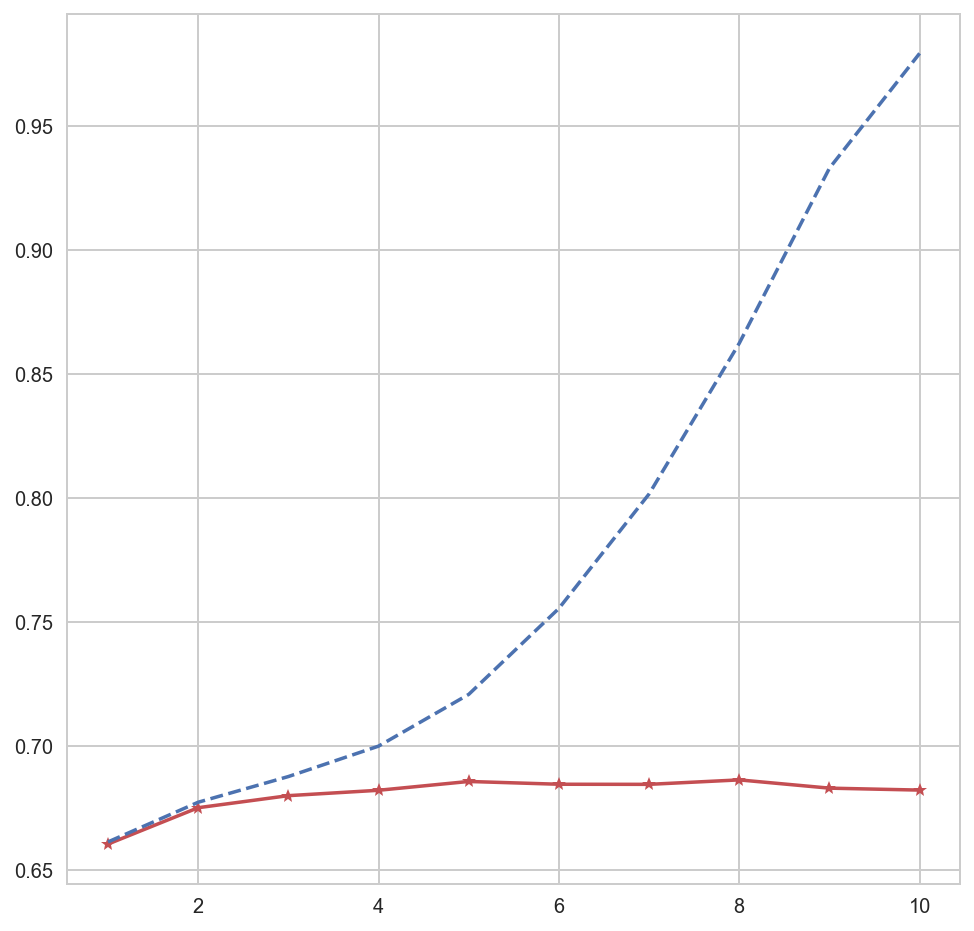

In [78]:
from sklearn.model_selection import cross_val_score, KFold
model_ls = []
score_ls = []
accur_ls = []

# tree 모델 자동생성 반복문
print("model creating..",end="")
for i in range(1,11):
    grad = GradientBoostingClassifier(n_estimators=100, max_depth=i, random_state=0).fit(df_data,df_target)
    print(",",i,end="")
    model_ls.append(grad)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_data, df_target,cv=10)
    accuracy = accuracy_score(df_target,model.predict(df_data))
    print(("Tree Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

# XGBoost

In [79]:
import xgboost

model_xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=5).fit(df_data,df_target)

model_xgb.predict_proba(df_data)

array([[ 0.50256622,  0.001959  ,  0.02096118,  0.42316392,  0.05134968],
       [ 0.62284392,  0.00321058,  0.01653169,  0.1055565 ,  0.25185725],
       [ 0.58800316,  0.00206582,  0.02726667,  0.25016752,  0.13249683],
       ..., 
       [ 0.21931186,  0.00206806,  0.06285172,  0.43723449,  0.27853382],
       [ 0.00308804,  0.01820995,  0.08343377,  0.00534671,  0.88992155],
       [ 0.0019079 ,  0.00683128,  0.06627713,  0.00113825,  0.92384541]], dtype=float32)

array([ 0.04758589,  0.11289074,  0.06019808,  0.        ,  0.06058496,
        0.04077685,  0.08727948,  0.01748685,  0.01864748,  0.01145156,
        0.02127824,  0.0872021 ,  0.13633551,  0.11173011,  0.18655215], dtype=float32)

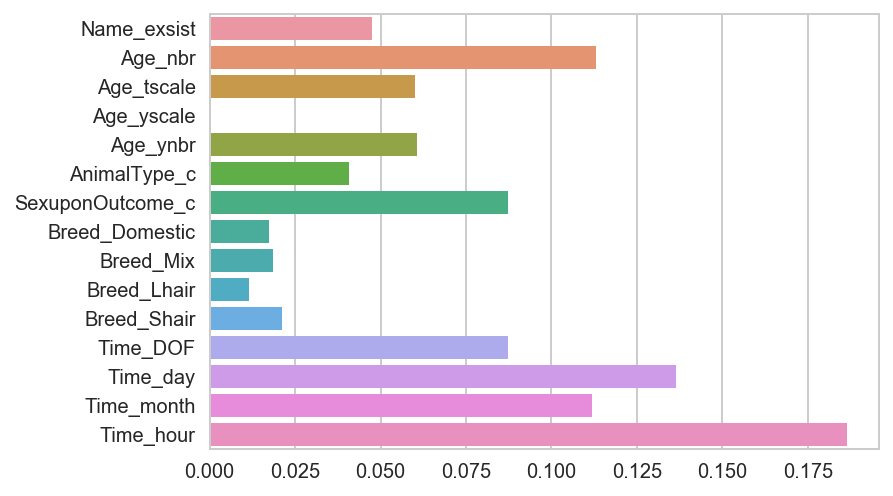

In [80]:
# 피쳐 중요도
importance = model_xgb.feature_importances_
sns.barplot(y=df_for_Naive.columns[1:], x=importance)
importance

model creating.., 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
model testing...
Tree Model1: Mean score: 0.655 --- acuraccy score : 0.655
Tree Model2: Mean score: 0.672 --- acuraccy score : 0.673
Tree Model3: Mean score: 0.676 --- acuraccy score : 0.681
Tree Model4: Mean score: 0.681 --- acuraccy score : 0.689
Tree Model5: Mean score: 0.686 --- acuraccy score : 0.700
Tree Model6: Mean score: 0.686 --- acuraccy score : 0.715
Tree Model7: Mean score: 0.688 --- acuraccy score : 0.734
Tree Model8: Mean score: 0.687 --- acuraccy score : 0.757
Tree Model9: Mean score: 0.688 --- acuraccy score : 0.793
Tree Model10: Mean score: 0.687 --- acuraccy score : 0.833


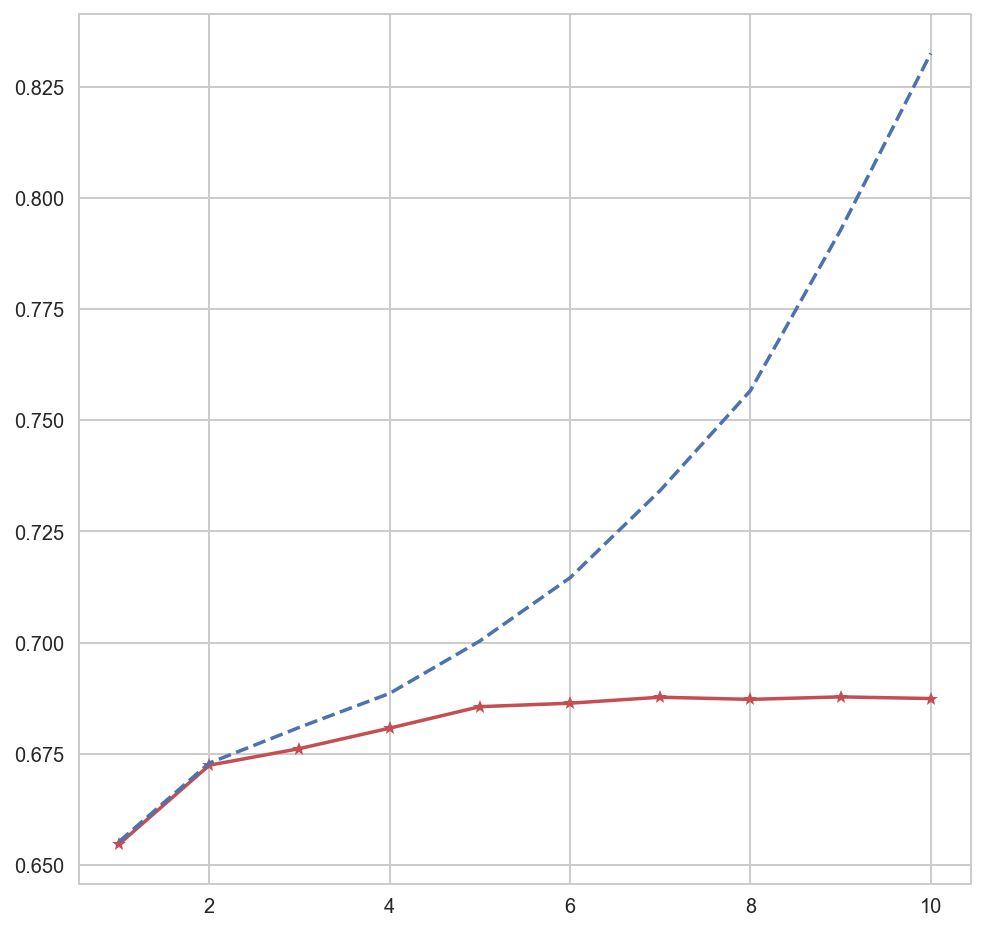

In [81]:
from sklearn.model_selection import cross_val_score, KFold
model_ls = []
score_ls = []
accur_ls = []

# tree 모델 자동생성 반복문
print("model creating..",end="")
for i in range(1,11):
    grad = xgboost.XGBClassifier(n_estimators=100, max_depth=i, random_state=0).fit(df_data,df_target)
    print(",",i,end="")
    model_ls.append(grad)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_data, df_target,cv=10)
    accuracy = accuracy_score(df_target,model.predict(df_data))
    print(("Tree Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

In [82]:
pdp.ProfileReport(df_shelter.iloc[:,10:])

Number of variables,35
Number of observations,26729
Total Missing (%),0.0%
Total size in memory,5.2 MiB
Average record size in memory,204.0 B
Numeric,15
Categorical,4
Boolean,15
Date,0
Text (Unique),0
Rejected,1


In [83]:
df_shelter.iloc[:,10:].corr()

,Name_exsist,Age_nbr,Age_ynbr,intact_b,sex_unknown,Male_b,Survived,Euthanasia_b,Transfer_b,Adoption_b,Died_b,Return_b,OutcomeType_c,OutcomeSubtype_c,AnimalType_c,SexuponOutcome_c,Breed_c,Color_c,Breed_Domestic,Breed_Mix,Breed_Lhair,Breed_Shair,Prediction_adopt,Prediction_Euthan,Prediction_Return,Prediction_Trans,Prediction_Died,Time_hour,Time_month,Time_day,Time_DOF
Name_exsist,1.000000,-0.138362,-0.227157,0.379714,0.309171,-0.080013,-0.143880,0.129770,0.382965,-0.239370,0.061175,-0.263859,0.276215,0.343133,-0.304307,-0.221540,-0.033129,-0.066860,0.303223,0.118886,0.012621,0.235629,-0.467292,0.379464,-0.602598,0.693025,0.693025,-0.090077,-0.012809,0.004618,-0.037486
Age_nbr,-0.138362,1.000000,0.675050,-0.096540,-0.069232,0.012870,-0.073940,0.084842,-0.101573,-0.074070,-0.018241,0.173597,0.024431,0.023317,0.127536,0.057805,0.021804,0.038849,-0.133785,-0.060514,0.031662,-0.121037,-0.188905,0.262161,0.474394,-0.248834,-0.248834,-0.016341,-0.010884,-0.003204,-0.000083
Age_ynbr,-0.227157,0.675050,1.000000,-0.138924,-0.104672,0.028446,-0.135793,0.151661,-0.160466,-0.154553,-0.022134,0.310018,0.066514,-0.001145,0.231762,0.079275,0.051635,0.076074,-0.239652,-0.077960,0.034806,-0.190504,-0.301715,0.443479,0.708015,-0.290384,-0.290384,-0.040206,-0.051454,-0.017827,-0.019208
intact_b,0.379714,-0.096540,-0.138924,1.000000,-0.123481,0.003895,-0.189417,0.170094,0.427445,-0.428469,0.082579,-0.106766,0.436242,0.309784,-0.191305,-0.844885,0.012897,-0.046652,0.189197,0.083472,0.001732,0.144264,-0.836447,0.497380,-0.259100,0.773517,0.773517,-0.166019,0.018385,0.018263,-0.050798
sex_unknown,0.309171,-0.069232,-0.104672,-0.123481,1.000000,-0.205649,-0.041424,0.030134,0.225043,-0.169693,0.037392,-0.090076,0.192076,0.177887,-0.214612,0.381838,-0.027800,-0.064743,0.218922,0.079903,-0.001755,0.176722,0.051579,0.088117,-0.204975,0.407244,0.407244,-0.055805,-0.041093,0.003144,-0.012032
Male_b,-0.080013,0.012870,0.028446,0.003895,-0.205649,1.000000,-0.014200,0.015030,-0.064007,0.003032,-0.000047,0.066714,-0.021541,-0.049537,0.083449,-0.261889,0.010961,-0.037900,-0.079107,-0.050208,-0.014614,-0.055846,0.005919,0.043951,0.152360,-0.107031,-0.107031,0.017342,0.007706,0.008389,-0.008560
Survived,-0.143880,-0.073940,-0.135793,-0.189417,-0.041424,-0.014200,1.000000,-0.938409,0.195415,0.217555,-0.325350,0.123690,0.027132,0.036717,0.039005,0.140672,-0.035536,0.016112,-0.038503,-0.033511,-0.024745,-0.006717,0.231191,-0.326804,0.020488,-0.166933,-0.166933,0.072672,0.004882,0.004542,0.043323
Euthanasia_b,0.129770,0.084842,0.151661,0.170094,0.030134,0.015030,-0.938409,1.000000,-0.183379,-0.204155,-0.021416,-0.116072,-0.009846,0.008517,-0.020186,-0.129899,0.039320,-0.010263,0.020275,0.028702,0.018516,-0.007726,-0.216001,0.333895,-0.001199,0.140507,0.140507,-0.053093,-0.005373,-0.003006,-0.045262
Transfer_b,0.382965,-0.101573,-0.160466,0.427445,0.225043,-0.064007,0.195415,-0.183379,1.000000,-0.606083,-0.063578,-0.344587,0.795314,0.539293,-0.251020,-0.295696,-0.026200,-0.045489,0.251249,0.082533,-0.002576,0.202847,-0.389147,0.179245,-0.305615,0.553963,0.553963,-0.255362,0.010903,0.007208,-0.079619
Adoption_b,-0.239370,-0.074070,-0.154553,-0.428469,-0.169693,0.003032,0.217555,-0.204155,-0.606083,1.000000,-0.070781,-0.383627,-0.950500,-0.433570,0.033087,0.315451,-0.038308,0.006345,-0.041290,-0.039334,0.005966,-0.022645,0.508224,-0.345149,-0.031326,-0.451922,-0.451922,0.239774,0.018345,0.006693,0.128867


In [84]:
df_shelter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 45 columns):
AnimalID             26729 non-null object
Name                 19038 non-null object
DateTime             26729 non-null object
OutcomeType          26729 non-null object
OutcomeSubtype       26729 non-null object
AnimalType           26729 non-null object
SexuponOutcome       26729 non-null object
AgeuponOutcome       26729 non-null object
Breed                26729 non-null object
Color                26729 non-null object
Name_exsist          26729 non-null int32
Age_nbr              26729 non-null int32
Age_tscale           26729 non-null object
Age_yscale           26729 non-null object
Age_ynbr             26729 non-null int32
Age_code             26729 non-null object
intact_b             26729 non-null int32
sex_unknown          26729 non-null int32
Male_b               26729 non-null int32
Survived             26729 non-null int64
Euthanasia_b         26729 non-null in

# 시간데이터 정제후 의사결정나무 모델적용

In [53]:
import datetime as dt

temp = pd.to_datetime(df_train_animal['DateTime'])

# sns.barplot(temp.dt.hour,bins=24)

# 시간데이터 정제
df_shelter["Time_hour"] = temp.dt.strftime("%H").astype(int)
df_shelter["Time_month"] = temp.dt.strftime("%m").astype(int)
df_shelter["Time_day"] = temp.dt.strftime("%d").astype(int)
df_shelter["Time_DOF"] = temp.dt.dayofweek.astype(int)
# df_shelter["Time_DOF"]
# df_shelter["Time_day"] = temp.dt.

In [54]:


# 시간데이터 정제
df_shelter["Time_hour"] = temp.dt.strftime("%H").astype(int)
df_shelter["Time_month"] = temp.dt.strftime("%m").astype(int)
df_shelter["Time_day"] = temp.dt.strftime("%d").astype(int)
df_shelter["Time_DOF"] = temp.dt.dayofweek.astype(int)
# df_shelter["Time_DOF"]
# df_shelter["Time_day"] = temp.dt.

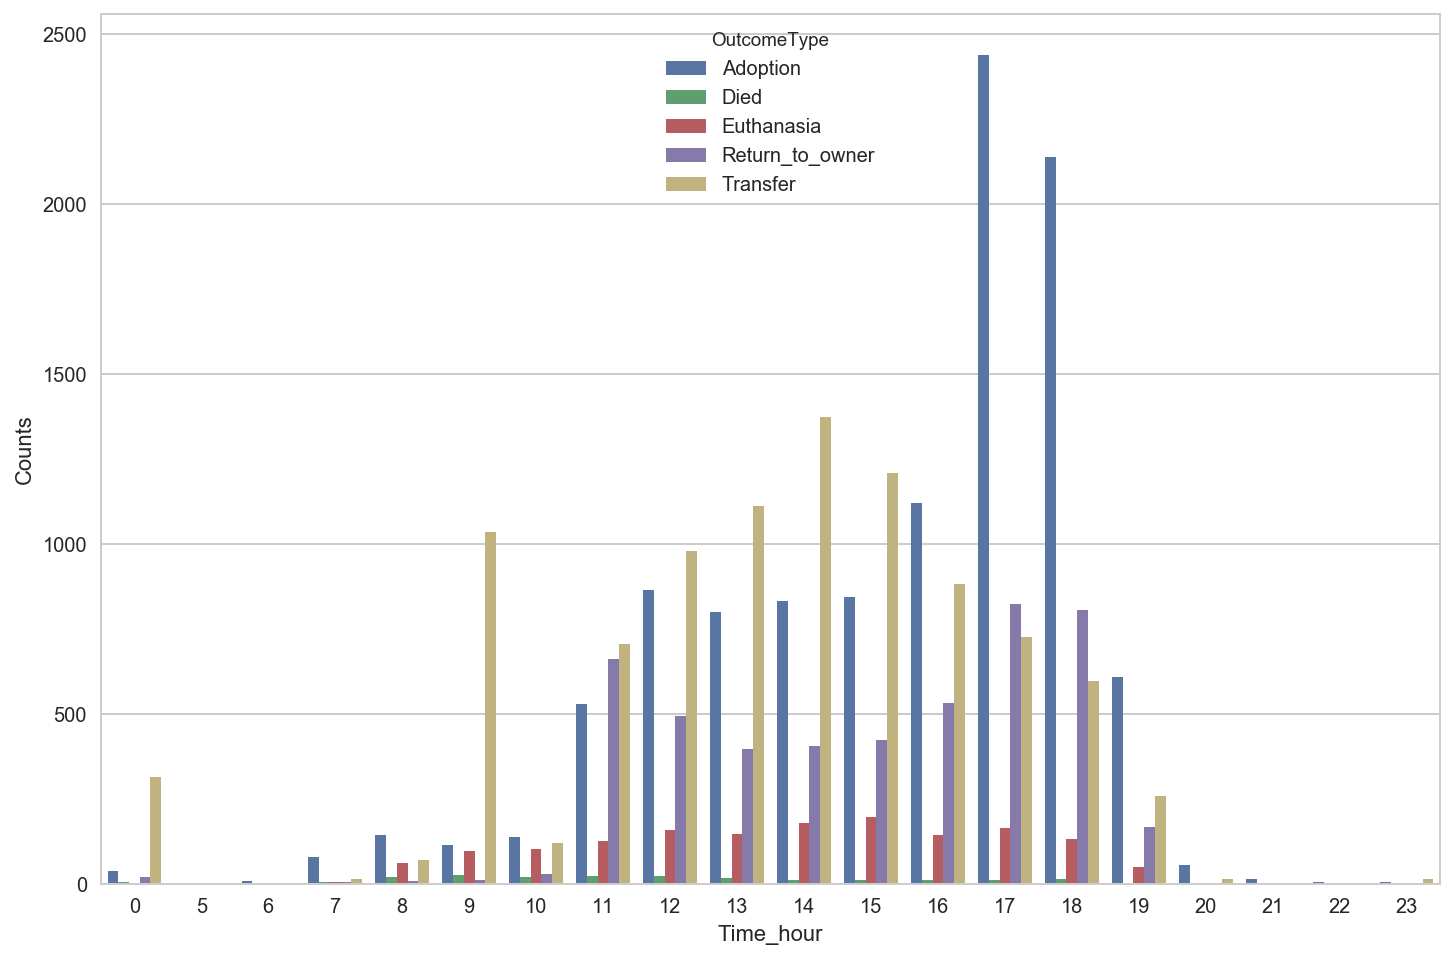

In [55]:

sorted_df = df_shelter.groupby(["OutcomeType","Time_hour"]).size().reset_index(name="count")
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="Time_hour", y="count", hue="OutcomeType")
ax.set_xlabel('Time_hour')
ax.set_ylabel('Counts')

# test.csv예측 --> Kaggle 제출

In [ ]:
df_test_animal = pd.read_csv("test.csv")
# print(df_train_animal.shape)
# df_train_animal.tail(3)

#개냐 고양이냐 선택하고 해보자
# 분석 베이스로 사용되는 데이터프레임 명칭지정 ==> df_test
df_test = df_test_animal[df_test_animal["AnimalType"]=="Cat"].copy()

# Name column --> 이름이 존재하는 동물과 그렇지 않은 동물을 구분하는 컬럼 생성
df_test["Name_exsist"] = df_test["Name"].isnull().astype(int)

# NaN값 처리
df_test["SexuponOutcome"] = df_test["SexuponOutcome"].fillna("Unknown")
df_test["AgeuponOutcome"] = df_test["AgeuponOutcome"].fillna("-1 nodata")

# 나이데이터 정제

df_test["Age_nbr"] = df_test["AgeuponOutcome"].str.slice(0,2).astype(int) # 0인값의경우 해당 동물의 나이정보가 없는것으로 추정한다
df_test["Age_tscale"] = df_test["AgeuponOutcome"].str.split(" ", n=2, expand=True)[1] # 띄어쓰기 된 뒷문장 가져오기
df_test["Age_tscale"] = df_test["Age_tscale"].replace("s","",regex=True) # 문자 s를 삭제
df_test["Age_yscale"] = df_test["Age_tscale"].replace(["day","week","month"],"under_year")
df_test["Age_ynbr"] = df_test["Age_nbr"].copy()
df_test.Age_ynbr[df_test["Age_yscale"]=="under_year"] = 0

df_test["Age_code"] = 'Y'

ls = []
for data in df_test.iloc[:,:].values:
    if data[-4] == "day":
        ls.append("D_"+str(data[-5]))
    elif data[-4] == "week":
        ls.append("K_"+str(data[-5]))
    elif data[-4] == "month":
        if (data[-5]>=10):
            ls.append("M_"+str(data[-5]))
        else : 
            ls.append("M_0"+str(data[-5]))
    elif data[-4] == "nodata":
        ls.append("A_nodata")
    elif data[-4] == "year":
        ls.append("Y_"+str(data[-5]))
df_test["Age_code"] = ls    


# 성별구분
df_test["intact_b"] = (df_test["SexuponOutcome"].str.slice(0,6) == "Intact").astype(int)
df_test["sex_unknown"] = (df_test["SexuponOutcome"] == "Unknown").astype(int)
df_test["Male_b"] = (df_test["SexuponOutcome"].str.split(' ', n=2, expand=True)[1] == "Male").astype(int)


#라벨인코딩 ()

from sklearn.preprocessing import LabelEncoder

AT = LabelEncoder()
y = df_test["AnimalType"]
AT.fit(y)
df_test["AnimalType_c"] = AT.transform(y)

SO = LabelEncoder()
y = df_test["SexuponOutcome"]
SO.fit(y)
df_test["SexuponOutcome_c"] = SO.transform(y)

Br = LabelEncoder()
y = df_test["Breed"]
Br.fit(y)
df_test["Breed_c"] = Br.transform(y)

Col = LabelEncoder()
y = df_test["Color"]
Col.fit(y)
df_test["Color_c"] = Col.transform(y)


# Breed 종류별 정제
# df_test = df_test.drop("Breed_domestic", axis=1)
df_test["Breed_normal"] = df_test["Breed"].replace(["Domestic","Mix"," ","Shorthair","Longhair",""],"",regex=True) # 문자 s를 삭제
df_test["Breed_Domestic"] = (df_test["Breed"].str.contains("Domestic", regex=True)).astype(int)
df_test["Breed_Mix"] = (df_test["Breed"].str.contains("Mix", regex=True)).astype(int)
df_test["Breed_Lhair"] = (df_test["Breed"].str.contains("Longhair", regex=True)).astype(int)
df_test["Breed_Shair"] = (df_test["Breed"].str.contains("Shorthair", regex=True)).astype(int)

import datetime as dt

# 시간데이터 정제
df_test["Time_hour"] = temp.dt.strftime("%H").astype(int)
df_test["Time_month"] = temp.dt.strftime("%m").astype(int)
df_test["Time_day"] = temp.dt.strftime("%d").astype(int)
df_test["Time_DOF"] = temp.dt.dayofweek.astype(int)
# df_test["Time_DOF"]
# df_test["Time_day"] = temp.dt.

In [ ]:
# 1차 기본정제

# 'Name_exsist', 'Age_nbr', 'Age_tscale', 'Age_yscale', 'Age_ynbr', 'Age_code', 'intact_b', 'sex_unknown', 'Male_b', 'Survived', 'Euthanasia_b', 'Transfer_b', 'Adoption_b', 'Died_b', 'Return_b', 'OutcomeType_c', 'OutcomeSubtype_c', 'AnimalType_c', 'SexuponOutcome_c', 'Breed_c', 'Color_c', 'Breed_normal', 'Breed_Domestic', 'Breed_Mix', 'Breed_Lhair', 'Breed_Shair'
df_classif = df_test[['Name_exsist', 'Age_nbr', 'Age_tscale', 'Age_yscale', 'Age_ynbr', 'AnimalType_c', 'SexuponOutcome_c', 'Breed_Domestic', 'Breed_Mix', 'Breed_Lhair', 'Breed_Shair', "Time_DOF", "Time_day", "Time_month", "Time_hour"]]

ATc = LabelEncoder()
y = df_classif["Age_tscale"]
ATc.fit(y)
df_classif["Age_tscale"] = ATc.transform(y)

AYc = LabelEncoder()
y = df_classif["Age_yscale"]
AYc.fit(y)
df_classif["Age_yscale"] = AYc.transform(y)

# -1 값이 있으므로 바꿔주는 작업이 필요하다.
df_classif.Age_nbr[df_classif["Age_nbr"] == -1] = 0
df_classif.Age_ynbr[df_classif["Age_ynbr"] == -1] = 0

# 2차 df -> np정제후 데이터 만들기

def getNpTarget1d(df, target_col_name, ls=[]):
    target_df = df[target_col_name].values
    return target_df

def getNpData1d(df, ls=[]):
    data_df = df[ls].values
    return data_df

ls = list(df_classif.columns.values[:])

# ts_target = getNpTarget1d(df_classif,"OutcomeType_c",ls) 
ts_data = getNpData1d(df_classif,ls) 

In [ ]:
ts_data[0]


In [ ]:
treeB = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=0).fit(df_data,df_target)

resultA = treeB.predict(ts_data)


from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y = [0,1,2,3,4]
lb.fit(y)
y2 = lb.transform(resultA)
y2
plt.hist(resultA, bins=5)

In [ ]:
submission = pd.DataFrame(y2, columns=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"])

submission["ID"] = np.arange(1,len(resultA)+1)
submission = submission[["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"]]
submission.tail()

# Late submission

In [ ]:
df_samplesub_animal = pd.read_csv("sample_submission.csv")
df_test_animal = pd.read_csv("test.csv")
print(df_samplesub_animal.shape,df_test_animal.shape)
df_test_animal.tail()
# df_samplesub_animal.tail()

In [ ]:
df_samplesub_animal.tail()

In [ ]:
submission.to_csv("submission5.csv",index=False)